# NB02: All Constraints Training v3.1

**Constraint-Based Architectural NCA - Step B v3.1**

**Version:** 3.1 (Loss Geometry Fix)
**Date:** December 2025
**Purpose:** Fix the dual-spill bug and improve corridor targeting

---

## What Failed in v3.0

v3.0 results:
- Path Align: 64% (FAIL, target >70%)
- Outside: 36% (FAIL, target <20%)
- Thickness: 69% (FAIL, target >90%)
- Fill Ratio: 21% (FAIL, target 5-15%)

**Root causes identified:**

1. **PathConnectivity and OutsideTarget are both "spill" losses** - Neither rewards COVERING the corridor
2. **Corridor computed dynamically** - Unstable targets each forward pass
3. **Thickness too permissive** - max_thickness=4 allows blobs
4. **Sparsity penalty too soft** - Hinge loss doesn't hurt enough
5. **No ground openness** - Nothing keeps street level clear

## v3.1 Fixes

| Issue | v3.0 | v3.1 |
|-------|------|------|
| Coverage vs Spill | Both spill | Split: Coverage + Spill |
| Corridor source | Current state | Seed state (frozen) |
| max_thickness | 4 | 2 |
| corridor_width | 3 | 4 |
| Sparsity | Hinge | Squared beyond threshold |
| Ground openness | None | Explicit loss |

## New Loss Architecture

| Loss | Purpose | Weight |
|------|---------|--------|
| LocalLegality | Where you CAN'T build | 30.0 |
| **CorridorCoverage** | Fill the corridor (A) | 25.0 |
| **CorridorSpill** | Don't grow outside (B) | 25.0 |
| **GroundOpenness** | Keep street open | 15.0 |
| Thickness | Prevent blobs | 20.0 |
| Sparsity | Volume limit (squared) | 25.0 |
| FacadeContact | Limit coating | 10.0 |
| AccessConnectivity | - | 15.0 |
| LoadPath | - | 8.0 |
| Cantilever | - | 5.0 |
| Density/TV | - | 4.0 |

---

## 1. Setup

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

PROJECT_ROOT = '/content/drive/MyDrive/Constraint-NCA'
print(f'Project root: {PROJECT_ROOT}')

Mounted at /content/drive
Project root: /content/drive/MyDrive/Constraint-NCA


In [2]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from typing import Dict, Tuple, Optional, List
import json
from datetime import datetime
from tqdm.notebook import tqdm
import os
from itertools import combinations

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')

Device: cuda
GPU: Tesla T4


In [3]:
# Set seeds
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

In [4]:
# Load Step B configuration
with open(f'{PROJECT_ROOT}/config_step_b.json', 'r') as f:
    CONFIG = json.load(f)

# v3.1 configuration - KEY CHANGES
CONFIG.update({
    'epochs': 500,
    'steps_min': 30,
    'steps_max': 50,
    'difficulty': 'easy',
    'log_every': 20,
    'viz_every': 100,
    'save_every': 100,
    'lr_initial': 7e-4,
    # v3.1 CHANGES
    'corridor_width': 1,       # Narrower corridors (was 3)
    'max_thickness': 2,        # Stricter thickness (was 4)
    'max_facade_contact': 0.15,
    'vertical_envelope': 1,    # NEW: allow corridor to extend vertically
    'corridor_seed_scale': 0.15,  # NEW: seed structure from corridor
    'corridor_mask_epochs': 20,  # NEW: hard mask early epochs
    'corridor_mask_anneal': 40,  # NEW: anneal mask to 0
    'ground_max_ratio': 0.04,  # NEW: cap total ground occupancy
    'street_levels': 6,        # NEW: keep z<=5 open
    'corridor_z_margin': 3,   # NEW: limit corridor height around access
}
)

print('v3.1 Configuration loaded')
print(f"Difficulty: {CONFIG['difficulty']}")
print(f"Epochs: {CONFIG['epochs']}")
print(f"Corridor width: {CONFIG['corridor_width']} (was 3)")
print(f"Max thickness: {CONFIG['max_thickness']} (was 4)")
print(f"Vertical envelope: {CONFIG['vertical_envelope']} (NEW)")

v3.1 Configuration loaded
Difficulty: easy
Epochs: 500
Corridor width: 1 (was 3)
Max thickness: 2 (was 4)
Vertical envelope: 1 (NEW)


## 2. Foundation Components

In [5]:
# ============================================================
# PERCEPTION MODULE (Unchanged)
# ============================================================

class Perceive3D(nn.Module):
    """3D Sobel perception with replicate padding."""

    def __init__(self, n_channels: int = 8):
        super().__init__()
        self.n_channels = n_channels

        sobel_x = self._create_sobel_kernel('x')
        sobel_y = self._create_sobel_kernel('y')
        sobel_z = self._create_sobel_kernel('z')
        identity = self._create_identity_kernel()

        kernels = torch.stack([identity, sobel_x, sobel_y, sobel_z], dim=0)
        self.register_buffer('kernels', kernels)

    def _create_sobel_kernel(self, direction: str) -> torch.Tensor:
        derivative = torch.tensor([-1., 0., 1.])
        smoothing = torch.tensor([1., 2., 1.])

        if direction == 'x':
            kernel = torch.einsum('i,j,k->ijk', smoothing, smoothing, derivative)
        elif direction == 'y':
            kernel = torch.einsum('i,j,k->ijk', smoothing, derivative, smoothing)
        elif direction == 'z':
            kernel = torch.einsum('i,j,k->ijk', derivative, smoothing, smoothing)
        return kernel / 16.0

    def _create_identity_kernel(self) -> torch.Tensor:
        kernel = torch.zeros(3, 3, 3)
        kernel[1, 1, 1] = 1.0
        return kernel

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, C, D, H, W = x.shape
        x_padded = F.pad(x, (1, 1, 1, 1, 1, 1), mode='replicate')

        outputs = []
        for k in range(4):
            kernel = self.kernels[k:k+1].unsqueeze(0).expand(C, 1, 3, 3, 3)
            out = F.conv3d(x_padded, kernel, padding=0, groups=C)
            outputs.append(out)
        return torch.cat(outputs, dim=1)

In [6]:
# ============================================================
# NCA MODEL (Unchanged)
# ============================================================

class UrbanPavilionNCA(nn.Module):
    """Neural Cellular Automaton for urban pavilion generation."""

    def __init__(self, config: dict):
        super().__init__()
        self.config = config

        n_channels = config['n_channels']
        hidden_dim = config['hidden_dim']
        perception_dim = n_channels * 4
        n_grown = config['n_grown']

        self.perceive = Perceive3D(n_channels)

        self.update_net = nn.Sequential(
            nn.Conv3d(perception_dim, hidden_dim, 1),
            nn.ReLU(),
            nn.Conv3d(hidden_dim, hidden_dim, 1),
            nn.ReLU(),
            nn.Conv3d(hidden_dim, n_grown, 1),
        )

        self._init_weights()

    def _init_weights(self):
        gain = self.config['xavier_gain']
        for m in self.update_net:
            if isinstance(m, nn.Conv3d):
                nn.init.xavier_uniform_(m.weight, gain=gain)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

        last_layer = self.update_net[-1]
        with torch.no_grad():
            last_layer.bias[0] = self.config['structure_bias']
            last_layer.bias[1] = self.config['surface_bias']

    def forward(self, state: torch.Tensor, steps: int = 1) -> torch.Tensor:
        for _ in range(steps):
            state = self._step(state)
        return state

    def _step(self, state: torch.Tensor) -> torch.Tensor:
        B, C, D, H, W = state.shape
        cfg = self.config

        perception = self.perceive(state)
        delta = self.update_net(perception)

        if self.training:
            fire_mask = (torch.rand(B, 1, D, H, W, device=state.device) < cfg['fire_rate']).float()
            delta = delta * fire_mask

        grown_start = cfg['n_frozen']
        grown_new = state[:, grown_start:] + cfg['update_scale'] * delta
        grown_new = torch.clamp(grown_new, 0.0, 1.0)

        # Hard mask: no structure inside buildings or illegal ground
        existing = state[:, cfg['ch_existing']:cfg['ch_existing']+1]
        available_mask = 1.0 - existing
        struct_new = grown_new[:, 0:1] * available_mask

        # Enforce legality if anchors/ground constraints are present
        if 'ch_anchors' in cfg:
            legality_field = LocalLegalityLoss(cfg).compute_legality_field(state)
            struct_new = struct_new * legality_field.unsqueeze(1)

        grown_masked = torch.cat([struct_new, grown_new[:, 1:]], dim=1)
        new_state = torch.cat([state[:, :grown_start], grown_masked], dim=1)

        return new_state

    def grow(self, seed: torch.Tensor, steps: int = 50) -> torch.Tensor:
        self.eval()
        with torch.no_grad():
            return self.forward(seed, steps)

In [7]:
# ============================================================
# SCENE GENERATOR (Unchanged from v3.0)
# ============================================================

class UrbanSceneGenerator:
    """Generate urban scenes with buildings, access points, and anchor zones."""

    def __init__(self, config: dict):
        self.config = config
        self.G = config['grid_size']
        self.C = config['n_channels']

    def generate(self, difficulty: str = 'easy',
                 device: str = 'cuda') -> Tuple[torch.Tensor, dict]:
        G = self.G
        cfg = self.config

        state = torch.zeros(1, self.C, G, G, G, device=device)
        state[:, cfg['ch_ground'], 0, :, :] = 1.0

        params = self._get_difficulty_params(difficulty)
        building_info = self._place_buildings(state, params)
        access_info = self._place_access_points(state, params, building_info)
        anchor_info = self._generate_anchor_zones(state, params, building_info, access_info)

        metadata = {
            'difficulty': difficulty,
            'buildings': building_info,
            'access_points': access_info,
            'anchor_zones': anchor_info,
            'gap_width': params['gap_width'],
        }

        return state, metadata

    def _get_difficulty_params(self, difficulty: str) -> dict:
        G = self.G
        if difficulty == 'easy':
            return {
                'n_buildings': 2, 'height_range': (14, 18), 'height_variance': False,
                'width_range': (8, 12), 'gap_width': random.randint(14, 18),
                'n_ground_access': 1, 'n_elevated_access': 1, 'anchor_budget': 0.10,
            }
        elif difficulty == 'medium':
            return {
                'n_buildings': 2, 'height_range': (12, 22), 'height_variance': True,
                'width_range': (6, 10), 'gap_width': random.randint(10, 14),
                'n_ground_access': random.randint(1, 2), 'n_elevated_access': random.randint(1, 2),
                'anchor_budget': 0.07,
            }
        else:  # hard
            return {
                'n_buildings': random.randint(2, 4), 'height_range': (10, 26), 'height_variance': True,
                'width_range': (5, 8), 'gap_width': random.randint(6, 10),
                'n_ground_access': random.randint(2, 3), 'n_elevated_access': random.randint(2, 3),
                'anchor_budget': 0.05,
            }

    def _place_buildings(self, state: torch.Tensor, params: dict) -> list:
        G = self.G
        ch = self.config['ch_existing']
        buildings = []
        gap_width = params['gap_width']
        gap_center = G // 2

        w1 = random.randint(*params['width_range'])
        d1 = random.randint(G//2, G-2)
        h1 = random.randint(*params['height_range'])
        x1_end = gap_center - gap_width // 2
        x1_start = max(0, x1_end - w1)
        state[:, ch, :h1, :d1, x1_start:x1_end] = 1.0
        buildings.append({'x': (x1_start, x1_end), 'y': (0, d1), 'z': (0, h1),
                         'gap_facing_x': x1_end, 'side': 'left'})

        w2 = random.randint(*params['width_range'])
        d2 = random.randint(G//2, G-2)
        h2 = h1 if not params['height_variance'] else random.randint(*params['height_range'])
        x2_start = gap_center + gap_width // 2
        x2_end = min(G, x2_start + w2)
        state[:, ch, :h2, :d2, x2_start:x2_end] = 1.0
        buildings.append({'x': (x2_start, x2_end), 'y': (0, d2), 'z': (0, h2),
                         'gap_facing_x': x2_start, 'side': 'right'})

        return buildings

    def _place_access_points(self, state: torch.Tensor, params: dict, buildings: list) -> list:
        G = self.G
        ch = self.config['ch_access']
        access_points = []

        total_access = params.get('n_ground_access', 0) + params.get('n_elevated_access', 1)
        used_z = set()

        for i in range(total_access):
            building = random.choice(buildings)
            bz_max = building['z'][1]
            is_left = building['side'] == 'left'

            z_min = 3
            z_max = max(z_min, bz_max - 2)

            z = None
            for _ in range(10):
                candidate = random.randint(z_min, z_max)
                if candidate not in used_z:
                    z = candidate
                    break
            if z is None:
                available = [zz for zz in range(z_min, z_max + 1) if zz not in used_z]
                z = random.choice(available) if available else z_min
            used_z.add(z)

            y = random.randint(building['y'][0], min(building['y'][1] - 2, building['y'][0] + G//3))
            x = building['x'][1] if is_left else building['x'][0] - 2
            x = max(0, min(G - 2, x))

            state[:, ch, z:z+2, y:y+2, x:x+2] = 1.0
            access_points.append({'x': x, 'y': y, 'z': z, 'type': 'facade'})

        return access_points

    def _generate_anchor_zones(self, state: torch.Tensor, params: dict,
                               buildings: list, access_points: list) -> dict:
        """Generate anchor zones - only around access points."""
        G = self.G
        ch = self.config['ch_anchors']
        street_levels = self.config['street_levels']

        existing = state[:, self.config['ch_existing'], 0, :, :]
        street_mask = 1.0 - existing
        total_street_area = street_mask.sum().item()

        anchors = torch.zeros(1, 1, G, G, G, device=state.device)

        for ap in access_points:
            if ap['type'] == 'ground':
                x, y = ap['x'], ap['y']
                for z in range(street_levels):
                    anchors[:, 0, z, max(0,y-2):min(G,y+4), max(0,x-2):min(G,x+4)] = 1.0

        for building in buildings:
            by_start, by_end = building['y']
            gap_x = building['gap_facing_x']
            is_left = building['side'] == 'left'
            x_start = gap_x if is_left else gap_x - 1
            x_end = gap_x + 1 if is_left else gap_x

            for z in range(street_levels):
                anchors[:, 0, z, by_start:min(by_start+4, by_end), max(0,x_start):min(G,x_end)] = 1.0

        for z in range(street_levels):
            anchors[:, 0, z, :, :] *= street_mask

        state[:, ch:ch+1, :, :, :] = anchors
        final_anchor_area = (anchors > 0.5).sum().item()

        return {'total_area': final_anchor_area, 'budget_ratio': params['anchor_budget'],
                'street_area': total_street_area}

    def batch(self, difficulty: str, batch_size: int, device: str) -> torch.Tensor:
        scenes = [self.generate(difficulty, device)[0] for _ in range(batch_size)]
        return torch.cat(scenes, dim=0)


print('Foundation components loaded')

Foundation components loaded


## 3. v3.1 Corridor Computation (IMPROVED)

Key changes:
1. Corridor computed from SEED state (frozen context)
2. 3D volume with vertical envelope (not just ground path)
3. Cached for stability

In [8]:
# ============================================================
# v3.1 CORRIDOR COMPUTATION (IMPROVED)
# ============================================================

def find_access_centroids(access_channel: torch.Tensor, threshold: float = 0.5) -> List[Tuple[int, int, int]]:
    """Find centroids of access point regions."""
    binary = (access_channel > threshold).float()
    if binary.sum() == 0:
        return []

    centroids = []
    D, H, W = binary.shape

    positions = (binary > 0).nonzero(as_tuple=False)
    if len(positions) == 0:
        return []

    used = set()
    for idx in range(len(positions)):
        if idx in used:
            continue

        pos = positions[idx]
        cluster = [pos]
        used.add(idx)

        for idx2 in range(idx + 1, len(positions)):
            if idx2 in used:
                continue
            pos2 = positions[idx2]
            dist = (pos - pos2).abs().sum().item()
            if dist <= 4:
                cluster.append(pos2)
                used.add(idx2)

        cluster = torch.stack(cluster).float()
        centroid = cluster.mean(dim=0).long()
        centroids.append((centroid[0].item(), centroid[1].item(), centroid[2].item()))

    return centroids


def compute_distance_field_3d(start_points: List[Tuple[int, int, int]],
                               legal_mask: torch.Tensor,
                               max_iters: int = 64) -> torch.Tensor:
    """Compute distance field from start points through legal space."""
    D, H, W = legal_mask.shape
    device = legal_mask.device

    distance = torch.full((D, H, W), float('inf'), device=device)

    for z, y, x in start_points:
        if 0 <= z < D and 0 <= y < H and 0 <= x < W:
            distance[z, y, x] = 0

    for _ in range(max_iters):
        dist_4d = distance.unsqueeze(0).unsqueeze(0)
        expanded = -F.max_pool3d(-dist_4d, 3, 1, 1).squeeze(0).squeeze(0)
        expanded = expanded + 1

        new_distance = torch.where(
            legal_mask > 0.5,
            torch.min(distance, expanded),
            distance
        )

        if torch.allclose(distance, new_distance, atol=1e-5):
            break
        distance = new_distance

    return distance




def _pairwise_dist(points):
    n = len(points)
    if n == 0:
        return []
    dists = [[0.0 for _ in range(n)] for _ in range(n)]
    for i in range(n):
        zi, yi, xi = points[i]
        for j in range(i + 1, n):
            zj, yj, xj = points[j]
            d = abs(zi - zj) + abs(yi - yj) + abs(xi - xj)
            dists[i][j] = d
            dists[j][i] = d
    return dists


def _compute_mst_edges(points):
    # Prim's algorithm over L1 distances; returns list of (i, j)
    n = len(points)
    if n < 2:
        return []
    dists = _pairwise_dist(points)
    in_tree = [False] * n
    in_tree[0] = True
    edges = []
    for _ in range(n - 1):
        best = None
        best_i = -1
        best_j = -1
        for i in range(n):
            if not in_tree[i]:
                continue
            for j in range(n):
                if in_tree[j]:
                    continue
                d = dists[i][j]
                if best is None or d < best:
                    best = d
                    best_i = i
                    best_j = j
        if best_j == -1:
            break
        in_tree[best_j] = True
        edges.append((best_i, best_j))
    return edges


def _compute_knn_edges(points, k=1):
    n = len(points)
    if n < 2:
        return []
    dists = _pairwise_dist(points)
    edges = set()
    for i in range(n):
        # get k nearest neighbors (excluding self)
        neighbors = sorted([(dists[i][j], j) for j in range(n) if j != i], key=lambda x: x[0])
        for _, j in neighbors[:k]:
            a, b = (i, j) if i < j else (j, i)
            edges.add((a, b))
    return list(edges)


def _extract_access_centroids(access_mask):
    # access_mask: [D,H,W] float/bool
    D, H, W = access_mask.shape
    visited = set()
    centroids = []

    def neighbors(z, y, x):
        for dz, dy, dx in [(1,0,0),(-1,0,0),(0,1,0),(0,-1,0),(0,0,1),(0,0,-1)]:
            nz, ny, nx = z+dz, y+dy, x+dx
            if 0 <= nz < D and 0 <= ny < H and 0 <= nx < W:
                yield nz, ny, nx

    for z in range(D):
        for y in range(H):
            for x in range(W):
                if access_mask[z, y, x] < 0.5:
                    continue
                if (z, y, x) in visited:
                    continue
                # BFS for connected component
                stack = [(z, y, x)]
                vox = []
                visited.add((z, y, x))
                while stack:
                    cz, cy, cx = stack.pop()
                    vox.append((cz, cy, cx))
                    for nz, ny, nx in neighbors(cz, cy, cx):
                        if access_mask[nz, ny, nx] < 0.5:
                            continue
                        if (nz, ny, nx) in visited:
                            continue
                        visited.add((nz, ny, nx))
                        stack.append((nz, ny, nx))
                # centroid
                if vox:
                    zz = sum(v[0] for v in vox) / len(vox)
                    yy = sum(v[1] for v in vox) / len(vox)
                    xx = sum(v[2] for v in vox) / len(vox)
                    centroids.append((int(round(zz)), int(round(yy)), int(round(xx))))
    return centroids
def compute_corridor_target_v31(seed_state: torch.Tensor, config: dict,
                                 corridor_width: int = 4,
                                 vertical_envelope: int = 3) -> torch.Tensor:
    """Compute 3D corridor target from SEED state (frozen).

    v3.1 IMPROVEMENTS:
    1. Uses seed state, not current state (stable target)
    2. Creates 3D volume with vertical envelope
    3. Includes elevated paths, not just ground
    """
    cfg = config
    G = cfg['grid_size']
    device = seed_state.device
    B = seed_state.shape[0]

    corridors = torch.zeros(B, G, G, G, device=device)

    for b in range(B):
        access = seed_state[b, cfg['ch_access']]
        existing = seed_state[b, cfg['ch_existing']]

        # Legal space = not in buildings
        legal_mask = 1.0 - existing

        # Find access point centroids
        centroids = _extract_access_centroids(access.detach().cpu())

        if len(centroids) < 2:
            # Fallback: dilated access
            dilated = F.max_pool3d(access.unsqueeze(0).unsqueeze(0),
                                   2*corridor_width+1, 1, corridor_width)
            corridors[b] = dilated.squeeze() * legal_mask
            continue

        corridor_mask = torch.zeros(G, G, G, device=device)

        edges = set(_compute_mst_edges(centroids))
        edges.update(_compute_knn_edges(centroids, k=1))
        edges = list(edges)

        for i_idx, j_idx in edges:
            start = centroids[i_idx]
            end = centroids[j_idx]

            # Compute distance from start
            dist_from_start = compute_distance_field_3d([start], legal_mask)

            # Compute distance from end
            dist_from_end = compute_distance_field_3d([end], legal_mask)

            # Total distance
            total_dist = dist_from_start[end[0], end[1], end[2]]

            if total_dist == float('inf'):
                continue

            # Path region with slack
            path_cost = dist_from_start + dist_from_end
            slack = corridor_width
            on_path = (path_cost <= total_dist + slack).float()

            corridor_mask = torch.max(corridor_mask, on_path)

        if corridor_mask.sum() > 0:
            # Dilate horizontally for width
            corridor_4d = corridor_mask.unsqueeze(0).unsqueeze(0)
            dilated = F.max_pool3d(corridor_4d, 2*corridor_width+1, 1, corridor_width)
            corridor_dilated = dilated.squeeze()
            # v3.1: Add vertical envelope (allow building up/down from path)
            # This makes elevated bridges count as "in corridor"
            if vertical_envelope > 0:
                # For each XY position, if any Z is in corridor, extend vertically
                xy_mask = corridor_dilated.max(dim=0)[0]  # [H, W]

                # Find min/max Z for each XY in path
                for z in range(G):
                    # Allow vertical extension around path levels
                    z_min = max(0, z - vertical_envelope)
                    z_max = min(G, z + vertical_envelope + 1)
                    if corridor_dilated[z_min:z_max].max(dim=0)[0].any():
                        # Extend where XY is in corridor
                        corridor_dilated[z] = torch.max(
                            corridor_dilated[z],
                            corridor_dilated[z_min:z_max].max(dim=0)[0]
                        )

            # Clamp corridor to a Z band around access points (after vertical envelope)
            if centroids and config.get('corridor_z_margin', None) is not None:
                z_vals = [c[0] for c in centroids]
                z_min = max(0, min(z_vals) - config['corridor_z_margin'])
                z_max = min(G, max(z_vals) + config['corridor_z_margin'] + 1)
                z_mask = torch.zeros_like(corridor_dilated)
                z_mask[z_min:z_max] = 1.0
                corridor_dilated = corridor_dilated * z_mask

            corridors[b] = corridor_dilated * legal_mask
        else:
            dilated = F.max_pool3d(access.unsqueeze(0).unsqueeze(0),
                                   2*corridor_width+1, 1, corridor_width)
            corridors[b] = dilated.squeeze() * legal_mask

    return corridors


print('v3.1 corridor computation defined (with vertical envelope)')

v3.1 corridor computation defined (with vertical envelope)


## 4. v3.1 Loss Functions (FIXED)

In [9]:
# ============================================================
# LOCAL LEGALITY (Unchanged)
# ============================================================

class LocalLegalityLoss(nn.Module):
    """Per-voxel legality enforcement."""

    def __init__(self, config: dict):
        super().__init__()
        self.config = config
        self.street_levels = config['street_levels']

    def compute_legality_field(self, state: torch.Tensor) -> torch.Tensor:
        cfg = self.config
        G = cfg['grid_size']
        street_levels = self.street_levels

        existing = state[:, cfg['ch_existing']]
        anchors = state[:, cfg['ch_anchors']]

        B = state.shape[0]
        device = state.device

        z_indices = torch.arange(G, device=device).view(1, G, 1, 1).expand(B, G, G, G)
        above_street = (z_indices >= street_levels).float()
        at_street = (z_indices < street_levels).float()

        position_legality = above_street + at_street * anchors
        legality = (1 - existing) * position_legality
        legality = torch.clamp(legality, 0, 1)

        return legality

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        cfg = self.config
        structure = state[:, cfg['ch_structure']]
        legality = self.compute_legality_field(state)
        illegal_structure = structure * (1 - legality)
        return illegal_structure.sum() / (structure.sum() + 1e-8)


print('LocalLegalityLoss defined')

LocalLegalityLoss defined


In [10]:
# ============================================================
# v3.1 CORRIDOR COVERAGE LOSS (NEW - was PathConnectivity)
# ============================================================

class CorridorCoverageLoss(nn.Module):
    """Penalize UNFILLED corridor - the model must cover the target.

    v3.1 FIX: This is objective (A) - "fill the corridor"

    v3.0 bug: PathConnectivityLoss used Dice which doesn't strongly
    penalize missing corridor voxels.

    Formula: L = unfilled_corridor / corridor_target
    """

    def __init__(self, config: dict):
        super().__init__()
        self.config = config

    def forward(self, structure: torch.Tensor, corridor_target: torch.Tensor) -> torch.Tensor:
        # Unfilled = corridor that has no structure
        unfilled = corridor_target * (1 - structure)

        # Penalty = fraction of corridor not filled
        return unfilled.sum() / (corridor_target.sum() + 1e-8)


print('CorridorCoverageLoss defined (NEW - objective A: fill the corridor)')

CorridorCoverageLoss defined (NEW - objective A: fill the corridor)


In [11]:
# ============================================================
# v3.1 CORRIDOR SPILL LOSS (was OutsideTarget)
# ============================================================

class CorridorSpillLoss(nn.Module):
    """Penalize structure OUTSIDE corridor - don't grow beyond target.

    v3.1: This is objective (B) - "don't spill outside"

    Now includes both:
    - Ratio penalty (fraction outside)
    - Absolute penalty (total outside voxels) - prevents gaming via mass
    """

    def __init__(self, config: dict, absolute_weight: float = 0.01):
        super().__init__()
        self.config = config
        self.absolute_weight = absolute_weight

    def forward(self, structure: torch.Tensor, corridor_target: torch.Tensor,
                legality_field: torch.Tensor) -> torch.Tensor:
        # Structure outside corridor (but legal - don't double-penalize)
        outside = structure * (1 - corridor_target) * legality_field

        # Ratio penalty
        ratio_penalty = outside.sum() / (structure.sum() + 1e-8)

        # Absolute penalty (scaled by grid size to normalize)
        G = self.config['grid_size']
        absolute_penalty = outside.sum() / (G * G * G)

        return ratio_penalty + self.absolute_weight * absolute_penalty


print('CorridorSpillLoss defined (objective B: dont grow outside)')

CorridorSpillLoss defined (objective B: dont grow outside)


In [12]:
# ============================================================
# v3.1 GROUND OPENNESS LOSS (NEW)
# ============================================================

class GroundOpennessLoss(nn.Module):
    """Keep street level open except where corridor requires it.

    NEW in v3.1

    Architectural intent: preserve pedestrian circulation at ground level.
    Only allow ground structure where the corridor target exists.
    """

    def __init__(self, config: dict):
        super().__init__()
        self.config = config
        self.street_levels = config['street_levels']

    def forward(self, structure: torch.Tensor, corridor_target: torch.Tensor,
                legality_field: torch.Tensor) -> torch.Tensor:
        street_levels = self.street_levels

        # Ground level structure
        ground_structure = structure[:, :street_levels, :, :]
        ground_corridor = corridor_target[:, :street_levels, :, :]
        ground_legal = legality_field[:, :street_levels, :, :]

        # Structure at ground that is NOT in corridor (and is legal)
        # This is structure blocking circulation unnecessarily
        unnecessary_ground = ground_structure * (1 - ground_corridor) * ground_legal

        # Penalty = fraction of ground structure that's unnecessary
        unnecessary_ratio = unnecessary_ground.sum() / (ground_structure.sum() + 1e-8)

        # Extra penalty: total ground occupancy (even inside corridor)
        ground_mass_ratio = ground_structure.sum() / (ground_legal.sum() + 1e-8)
        ground_cap = self.config.get('ground_max_ratio', 0.05)
        mass_penalty = F.relu(ground_mass_ratio - ground_cap)

        return unnecessary_ratio + mass_penalty


print('GroundOpennessLoss defined (NEW - preserve street circulation)')

GroundOpennessLoss defined (NEW - preserve street circulation)


In [13]:
# ============================================================
# v3.1 THICKNESS LOSS (TIGHTENED)
# ============================================================

class ThicknessLoss(nn.Module):
    """Penalize blob-like thick structures.

    v3.1 CHANGE: max_thickness reduced from 4 to 2

    With corridor_width=4 and max_thickness=2, we allow
    corridors but not blobs.
    """

    def __init__(self, max_thickness: int = 2):
        super().__init__()
        self.max_thickness = max_thickness

    def erode_3d(self, x: torch.Tensor) -> torch.Tensor:
        """Morphological erosion via min-pooling."""
        x_4d = x.unsqueeze(1) if x.dim() == 4 else x.unsqueeze(0).unsqueeze(0)
        eroded = -F.max_pool3d(-x_4d, 3, 1, 1)
        return eroded.squeeze(1) if x.dim() == 4 else eroded.squeeze(0).squeeze(0)

    def forward(self, structure: torch.Tensor) -> torch.Tensor:
        struct_soft = torch.sigmoid(10 * (structure - 0.3))

        core = struct_soft
        for _ in range(self.max_thickness):
            core = self.erode_3d(core)

        return core.sum() / (struct_soft.sum() + 1e-8)


print(f'ThicknessLoss defined (max_thickness=2, was 4)')

ThicknessLoss defined (max_thickness=2, was 4)


In [14]:
# ============================================================
# v3.1 SPARSITY LOSS (SHARPER)
# ============================================================

class SparsityLossV31(nn.Module):
    """Limit total volume with SQUARED penalty beyond threshold.

    v3.1 CHANGE: Squared penalty makes exceeding 15% much more costly.

    L = (ratio - max_ratio)^2  if ratio > max_ratio
    """

    def __init__(self, max_ratio: float = 0.12, min_ratio: float = 0.03,
                 under_coef: float = 1.0, squared: bool = True):
        super().__init__()
        self.max_ratio = max_ratio
        self.min_ratio = min_ratio
        self.under_coef = under_coef
        self.squared = squared

    def forward(self, structure: torch.Tensor, available: torch.Tensor) -> torch.Tensor:
        ratio = structure.sum() / (available.sum() + 1e-8)

        # Over penalty - SQUARED for sharper cutoff
        over = F.relu(ratio - self.max_ratio)
        if self.squared:
            over_penalty = over ** 2 * 150  # Scale up squared term
        else:
            over_penalty = over

        # Under penalty
        under_penalty = self.under_coef * F.relu(self.min_ratio - ratio)

        return over_penalty + under_penalty


print('SparsityLossV31 defined (squared penalty for sharper cutoff)')

SparsityLossV31 defined (squared penalty for sharper cutoff)


In [15]:
# ============================================================
# REMAINING LOSSES (Unchanged)
# ============================================================

class FacadeContactLoss(nn.Module):
    """Limit structure contact with existing buildings."""

    def __init__(self, config: dict, max_contact_ratio: float = 0.15):
        super().__init__()
        self.config = config
        self.max_contact_ratio = max_contact_ratio

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        cfg = self.config
        structure = state[:, cfg['ch_structure']]
        existing = state[:, cfg['ch_existing']]

        existing_4d = existing.unsqueeze(1)
        dilated = F.max_pool3d(existing_4d, 3, 1, 1).squeeze(1)
        facade_zone = torch.clamp(dilated - existing, 0, 1)

        contact = (structure * facade_zone).sum()
        total_structure = structure.sum() + 1e-8
        contact_ratio = contact / total_structure

        return F.relu(contact_ratio - self.max_contact_ratio)


class AccessConnectivityLoss(nn.Module):
    """Street connectivity seeded from access points."""

    def __init__(self, config: dict, iterations: int = 32):
        super().__init__()
        self.config = config
        self.street_levels = config['street_levels']
        self.iterations = iterations

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        cfg = self.config
        street_levels = self.street_levels

        structure = state[:, cfg['ch_structure'], :street_levels, :, :]
        existing = state[:, cfg['ch_existing'], :street_levels, :, :]
        access = state[:, cfg['ch_access'], :street_levels, :, :]

        void_mask = (1 - structure) * (1 - existing)
        access_seed = F.max_pool3d(access.unsqueeze(1), 3, 1, 1).squeeze(1)
        connected = access_seed * void_mask

        for _ in range(self.iterations):
            dilated = F.max_pool3d(connected.unsqueeze(1), 3, 1, 1).squeeze(1)
            new_connected = torch.max(connected, dilated * void_mask)
            if torch.allclose(connected, new_connected, atol=1e-5):
                break
            connected = new_connected

        access_locations = (access > 0.5).float()
        reachable = (connected * access_locations).sum()
        total_access = access_locations.sum() + 1e-8

        return 1 - (reachable / total_access)


class LoadPathLoss(nn.Module):
    """Structural load path connectivity."""

    def __init__(self, config: dict, iterations: int = 32):
        super().__init__()
        self.config = config
        self.street_levels = config['street_levels']
        self.iterations = iterations

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        cfg = self.config
        street_levels = self.street_levels

        structure = state[:, cfg['ch_structure']]
        existing = state[:, cfg['ch_existing']]
        anchors = state[:, cfg['ch_anchors']]

        support_street = torch.max(
            existing[:, :street_levels, :, :],
            anchors[:, :street_levels, :, :]
        )
        support_above = existing[:, street_levels:, :, :]
        support = torch.cat([support_street, support_above], dim=1)

        connected = support.clone()
        struct_soft = torch.sigmoid(10 * (structure - 0.3))

        for _ in range(self.iterations):
            dilated = F.max_pool3d(connected.unsqueeze(1), 3, 1, 1).squeeze(1)
            new_connected = torch.max(connected, dilated * struct_soft)
            if torch.allclose(connected, new_connected, atol=1e-5):
                break
            connected = new_connected

        elevated = structure[:, street_levels:, :, :]
        elevated_connected = connected[:, street_levels:, :, :]
        unsupported = elevated * (1 - elevated_connected)

        return unsupported.sum() / (elevated.sum() + 1e-8)


class CantileverLoss(nn.Module):
    """Limit horizontal overhangs."""

    def __init__(self, max_overhang: int = 3, threshold: float = 0.3):
        super().__init__()
        self.max_overhang = max_overhang
        self.threshold = threshold

    def forward(self, structure: torch.Tensor) -> torch.Tensor:
        B, D, H, W = structure.shape
        N = self.max_overhang
        total_loss = 0.0
        count = 0

        for z in range(N, D):
            layer = structure[:, z]
            support_volume = structure[:, max(0, z-N):z]
            support_max = support_volume.max(dim=1)[0]
            support_dilated = F.max_pool2d(support_max.unsqueeze(1), 3, 1, 1).squeeze(1)
            has_support = torch.sigmoid(10 * (support_dilated - self.threshold))
            unsupported = layer * (1.0 - has_support)
            total_loss += unsupported.mean()
            count += 1

        return total_loss / max(1, count)


class DensityPenalty(nn.Module):
    """SIMP density penalty for binary outputs."""
    def forward(self, structure: torch.Tensor) -> torch.Tensor:
        return (structure * (1.0 - structure)).mean()


class TotalVariation3D(nn.Module):
    """Total variation for smooth surfaces."""
    def forward(self, structure: torch.Tensor) -> torch.Tensor:
        tv_d = (structure[:, 1:, :, :] - structure[:, :-1, :, :]).abs().mean()
        tv_h = (structure[:, :, 1:, :] - structure[:, :, :-1, :]).abs().mean()
        tv_w = (structure[:, :, :, 1:] - structure[:, :, :, :-1]).abs().mean()
        return tv_d + tv_h + tv_w


print('Remaining losses defined')

Remaining losses defined


In [16]:
# Test all v3.1 losses
print('Testing v3.1 loss functions...')
print('='*60)

scene_gen = UrbanSceneGenerator(CONFIG)
scene, meta = scene_gen.generate('easy', device)

# Add test structure
test_state = scene.clone()
test_state[:, CONFIG['ch_structure'], 2:10, 10:20, 12:20] = 0.6
anchors = test_state[:, CONFIG['ch_anchors']]
test_state[:, CONFIG['ch_structure'], 0:2, :, :] = 0.6 * anchors[:, 0:2, :, :]

structure = test_state[:, CONFIG['ch_structure']]
existing = test_state[:, CONFIG['ch_existing']]
available = 1.0 - existing

# Compute corridor from SEED (not current state)
corridor_target = compute_corridor_target_v31(
    scene, CONFIG,  # Use SEED, not test_state
    corridor_width=CONFIG['corridor_width'],
    vertical_envelope=CONFIG['vertical_envelope']
)

# Test losses
legality_loss = LocalLegalityLoss(CONFIG)
legality_field = legality_loss.compute_legality_field(test_state)
print(f'LocalLegality: {legality_loss(test_state).item():.4f}')

coverage_loss = CorridorCoverageLoss(CONFIG)
print(f'CorridorCoverage: {coverage_loss(structure, corridor_target).item():.4f}')

spill_loss = CorridorSpillLoss(CONFIG)
print(f'CorridorSpill: {spill_loss(structure, corridor_target, legality_field).item():.4f}')

ground_loss = GroundOpennessLoss(CONFIG)
print(f'GroundOpenness: {ground_loss(structure, corridor_target, legality_field).item():.4f}')

thickness_loss = ThicknessLoss(max_thickness=CONFIG['max_thickness'])
print(f'Thickness: {thickness_loss(structure).item():.4f}')

sparsity_loss = SparsityLossV31()
print(f'Sparsity: {sparsity_loss(structure, available).item():.4f}')

facade_loss = FacadeContactLoss(CONFIG, max_contact_ratio=CONFIG['max_facade_contact'])
print(f'FacadeContact: {facade_loss(test_state).item():.4f}')

access_conn = AccessConnectivityLoss(CONFIG)
print(f'AccessConnectivity: {access_conn(test_state).item():.4f}')

loadpath = LoadPathLoss(CONFIG)
print(f'LoadPath: {loadpath(test_state).item():.4f}')

print(f'Cantilever: {CantileverLoss()(structure).item():.4f}')
print(f'Density: {DensityPenalty()(structure).item():.4f}')
print(f'TV: {TotalVariation3D()(structure).item():.4f}')

print('='*60)
print('All v3.1 loss functions working')

Testing v3.1 loss functions...
LocalLegality: 0.4878
CorridorCoverage: 1.0000
CorridorSpill: 0.5123
GroundOpenness: 4.2076
Thickness: 0.7640
Sparsity: 0.0152
FacadeContact: 0.0000
AccessConnectivity: 1.0000
LoadPath: 0.9999
Cantilever: 0.0005
Density: 0.0048
TV: 0.0093
All v3.1 loss functions working


## 5. Evaluation Metrics (v3.1)

In [17]:
def compute_legality_compliance(state: torch.Tensor, config: dict) -> torch.Tensor:
    """Fraction of structure in legal zones. Target: 100%"""
    legality_loss = LocalLegalityLoss(config)
    legality_field = legality_loss.compute_legality_field(state)
    structure = state[:, config['ch_structure']]
    legal_structure = (structure * legality_field).sum()
    return legal_structure / (structure.sum() + 1e-8)


def compute_corridor_coverage(structure: torch.Tensor, corridor_target: torch.Tensor) -> torch.Tensor:
    """Fraction of corridor that is filled. Target: >70%"""
    filled = (structure * corridor_target).sum()
    return filled / (corridor_target.sum() + 1e-8)


def compute_corridor_spill(structure: torch.Tensor, corridor_target: torch.Tensor,
                           legality_field: torch.Tensor) -> torch.Tensor:
    """Fraction of structure outside corridor. Target: <20%"""
    outside = structure * (1 - corridor_target) * legality_field
    return outside.sum() / (structure.sum() + 1e-8)


def compute_thickness_compliance(state: torch.Tensor, config: dict) -> float:
    """Fraction of structure that is NOT blob core. Target: >90%"""
    structure = state[:, config['ch_structure']]
    thickness_loss = ThicknessLoss(config.get('max_thickness', 2))
    core_ratio = thickness_loss(structure).item()
    return 1.0 - core_ratio


def compute_ground_openness(structure: torch.Tensor, corridor_target: torch.Tensor,
                            legality_field: torch.Tensor, config: dict) -> torch.Tensor:
    """Fraction of ground structure that is in corridor. Target: >80%"""
    street_levels = config['street_levels']
    ground_struct = structure[:, :street_levels, :, :]
    ground_corr = corridor_target[:, :street_levels, :, :]
    in_corridor = (ground_struct * ground_corr).sum()
    return in_corridor / (ground_struct.sum() + 1e-8)


def compute_facade_contact(state: torch.Tensor, config: dict) -> torch.Tensor:
    """Fraction of structure touching facades. Target: <15%"""
    structure = state[:, config['ch_structure']]
    existing = state[:, config['ch_existing']]
    existing_4d = existing.unsqueeze(1)
    dilated = F.max_pool3d(existing_4d, 3, 1, 1).squeeze(1)
    facade_zone = torch.clamp(dilated - existing, 0, 1)
    contact = (structure * facade_zone).sum()
    return contact / (structure.sum() + 1e-8)


def compute_load_path_compliance(state: torch.Tensor, config: dict) -> torch.Tensor:
    """Fraction of elevated structure connected. Target: >95%"""
    loadpath = LoadPathLoss(config)
    return 1.0 - loadpath(state)


def compute_access_reachability(state: torch.Tensor, config: dict) -> torch.Tensor:
    """Fraction of access points mutually reachable. Target: >90%"""
    access_conn = AccessConnectivityLoss(config)
    return 1.0 - access_conn(state)


def compute_fill_ratio(state: torch.Tensor, config: dict) -> torch.Tensor:
    """Total volume ratio. Target: 5-15%"""
    structure = state[:, config['ch_structure']]
    existing = state[:, config['ch_existing']]
    available = 1.0 - existing
    return structure.sum() / (available.sum() + 1e-8)


print('v3.1 evaluation metrics defined')

v3.1 evaluation metrics defined


## 6. v3.1 Trainer (FIXED)

In [18]:
class ArchitecturalIntentTrainerV31:
    """Step B v3.1 Trainer: Fixed Loss Geometry.

    KEY FIXES:
    1. Split Coverage (A) and Spill (B) into separate losses
    2. Corridor computed from SEED (frozen), not current state
    3. Added GroundOpenness loss
    4. Tighter thickness (2 vs 4)
    5. Squared sparsity penalty
    """

    def __init__(self, model: nn.Module, config: dict, device: str):
        self.model = model
        self.config = config
        self.device = device

        max_thickness = config.get('max_thickness', 2)
        max_facade = config.get('max_facade_contact', 0.15)

        # v3.1 loss functions
        self.legality_loss = LocalLegalityLoss(config)
        self.coverage_loss = CorridorCoverageLoss(config)  # NEW (A)
        self.spill_loss = CorridorSpillLoss(config)        # RENAMED (B)
        self.ground_loss = GroundOpennessLoss(config)      # NEW
        self.thickness_loss = ThicknessLoss(max_thickness)
        self.sparsity_loss = SparsityLossV31(squared=True) # IMPROVED
        self.facade_loss = FacadeContactLoss(config, max_facade)
        self.access_conn_loss = AccessConnectivityLoss(config)
        self.loadpath_loss = LoadPathLoss(config)
        self.cantilever_loss = CantileverLoss()
        self.density_loss = DensityPenalty()
        self.tv_loss = TotalVariation3D()

        # v3.1 weights (REBALANCED)
        self.weights = {
            'legality': 30.0,
            'coverage': 25.0,       # (A) Fill the corridor
            'spill': 25.0,          # (B) Don't grow outside
            'ground': 35.0,         # NEW: Keep ground open
            'thickness': 30.0,      # Increased (was 15)
            'sparsity': 30.0,       # Increased (was 15)
            'facade': 10.0,
            'access_conn': 15.0,
            'loadpath': 8.0,        # Reduced (was 10)
            'cantilever': 5.0,
            'density': 3.0,
            'tv': 1.0,
        }

        self.optimizer = torch.optim.Adam(model.parameters(), lr=config['lr_initial'])
        self.scene_gen = UrbanSceneGenerator(config)
        self.history = []

    def train_epoch(self, epoch: int) -> dict:
        self.model.train()
        cfg = self.config

        # Generate seeds
        seeds = self.scene_gen.batch(cfg['difficulty'], cfg['batch_size'], self.device)

        # v3.1 KEY: Compute corridor from SEED (frozen context)
        with torch.no_grad():
            corridor_target = compute_corridor_target_v31(
                seeds, cfg,
                corridor_width=cfg.get('corridor_width', 4),
                vertical_envelope=cfg.get('vertical_envelope', 3)
            )
        # Seed structure from corridor target (early scaffold)
        seed_scale = cfg.get('corridor_seed_scale', 0.0)
        if seed_scale > 0:
            struct_idx = cfg['ch_structure']
            seeds[:, struct_idx] = torch.clamp(seeds[:, struct_idx] + seed_scale * corridor_target, 0.0, 1.0)
            corridor_total = corridor_target.sum().item()
            corridor_ground = corridor_target[:, :cfg['street_levels']].sum().item()
            legality_seed = self.legality_loss.compute_legality_field(seeds)
            corridor_legal = (corridor_target * legality_seed).sum().item()
            corridor_legal_pct = 100.0 * corridor_legal / max(corridor_total, 1.0)
            corridor_fraction = corridor_total / (seeds.shape[0] * cfg['grid_size']**3)
            access_count = -1
            if epoch % cfg.get('log_every', 20) == 0:
                access_count = 0
                for b in range(seeds.shape[0]):
                    access_count += len(_extract_access_centroids(seeds[b, cfg['ch_access']].detach().cpu()))

                # Apply corridor-only growth mask early, then anneal
        mask_epochs = cfg.get('corridor_mask_epochs', 0)
        mask_anneal = cfg.get('corridor_mask_anneal', 0)
        mask_strength = 0.0
        if epoch < mask_epochs:
            mask_strength = 1.0
        elif mask_anneal > 0 and epoch < mask_epochs + mask_anneal:
            mask_strength = 1.0 - (epoch - mask_epochs) / float(mask_anneal)

        if mask_strength > 0:
            struct_idx = cfg['ch_structure']
            # Keep only corridor volume in structure channel
            seeds[:, struct_idx] = seeds[:, struct_idx] * (1.0 - mask_strength) + seeds[:, struct_idx] * corridor_target * mask_strength

        steps = random.randint(cfg['steps_min'], cfg['steps_max'])
        final = self.model(seeds, steps=steps)

        structure = final[:, cfg['ch_structure']]
        existing = final[:, cfg['ch_existing']]
        available = 1.0 - existing

        # Compute legality field
        legality_field = self.legality_loss.compute_legality_field(final)

        # Compute all losses
        L_legality = self.legality_loss(final)
        L_coverage = self.coverage_loss(structure, corridor_target)  # (A)
        L_spill = self.spill_loss(structure, corridor_target, legality_field)  # (B)
        L_ground = self.ground_loss(structure, corridor_target, legality_field)  # NEW
        L_thickness = self.thickness_loss(structure)
        L_sparsity = self.sparsity_loss(structure, available)
        L_facade = self.facade_loss(final)
        L_access_conn = self.access_conn_loss(final)
        L_loadpath = self.loadpath_loss(final)
        L_cant = self.cantilever_loss(structure)
        L_density = self.density_loss(structure)
        L_tv = self.tv_loss(structure)

        # Total loss
        total_loss = (
            self.weights['legality'] * L_legality +
            self.weights['coverage'] * L_coverage +
            self.weights['spill'] * L_spill +
            self.weights['ground'] * L_ground +
            self.weights['thickness'] * L_thickness +
            self.weights['sparsity'] * L_sparsity +
            self.weights['facade'] * L_facade +
            self.weights['access_conn'] * L_access_conn +
            self.weights['loadpath'] * L_loadpath +
            self.weights['cantilever'] * L_cant +
            self.weights['density'] * L_density +
            self.weights['tv'] * L_tv
        )

        self.optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), cfg['grad_clip'])
        self.optimizer.step()

        # Metrics
        with torch.no_grad():
            metrics = {
                'epoch': epoch,
                'total_loss': total_loss.item(),
                'L_legality': L_legality.item(),
                'L_coverage': L_coverage.item(),
                'L_spill': L_spill.item(),
                'L_ground': L_ground.item(),
                'L_thickness': L_thickness.item(),
                'L_sparsity': L_sparsity.item(),
                'legality': compute_legality_compliance(final, cfg).item(),
                'coverage': compute_corridor_coverage(structure, corridor_target).item(),
                'spill': compute_corridor_spill(structure, corridor_target, legality_field).item(),
                'ground_open': compute_ground_openness(structure, corridor_target, legality_field, cfg).item(),
                'thickness': compute_thickness_compliance(final, cfg),
                'facade': compute_facade_contact(final, cfg).item(),
                'loadpath': compute_load_path_compliance(final, cfg).item(),
                'access_reach': compute_access_reachability(final, cfg).item(),
                'fill_ratio': compute_fill_ratio(final, cfg).item(),
                'steps': steps,
                'corr_total': corridor_total,
                'corr_ground': corridor_ground,
                'corr_legal_pct': corridor_legal_pct,
                'access_centroids': access_count,
                'corridor_fraction': corridor_fraction,
            }

        self.history.append(metrics)
        return metrics

    def evaluate(self, n_samples: int = 20) -> dict:
        self.model.eval()
        cfg = self.config
        results = []

        with torch.no_grad():
            for _ in range(n_samples):
                scene, _ = self.scene_gen.generate(cfg['difficulty'], self.device)

                # Compute corridor from seed
                corridor_target = compute_corridor_target_v31(
                    scene, cfg,
                    corridor_width=cfg.get('corridor_width', 4),
                    vertical_envelope=cfg.get('vertical_envelope', 3)
                )

                grown = self.model.grow(scene, steps=50)
                structure = grown[:, cfg['ch_structure']]
                legality_field = self.legality_loss.compute_legality_field(grown)

                results.append({
                    'legality': compute_legality_compliance(grown, cfg).item(),
                    'coverage': compute_corridor_coverage(structure, corridor_target).item(),
                    'spill': compute_corridor_spill(structure, corridor_target, legality_field).item(),
                    'ground_open': compute_ground_openness(structure, corridor_target, legality_field, cfg).item(),
                    'thickness': compute_thickness_compliance(grown, cfg),
                    'facade': compute_facade_contact(grown, cfg).item(),
                    'loadpath': compute_load_path_compliance(grown, cfg).item(),
                    'access_reach': compute_access_reachability(grown, cfg).item(),
                    'fill_ratio': compute_fill_ratio(grown, cfg).item(),
                })

        return {
            'avg_legality': np.mean([r['legality'] for r in results]),
            'avg_coverage': np.mean([r['coverage'] for r in results]),
            'avg_spill': np.mean([r['spill'] for r in results]),
            'avg_ground_open': np.mean([r['ground_open'] for r in results]),
            'avg_thickness': np.mean([r['thickness'] for r in results]),
            'avg_facade': np.mean([r['facade'] for r in results]),
            'avg_loadpath': np.mean([r['loadpath'] for r in results]),
            'avg_access_reach': np.mean([r['access_reach'] for r in results]),
            'avg_fill_ratio': np.mean([r['fill_ratio'] for r in results]),
            'n_samples': n_samples,
        }

    def save_checkpoint(self, path: str):
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'config': self.config,
            'history': self.history,
            'weights': self.weights,
        }, path)
        print(f'Checkpoint saved: {path}')


print('ArchitecturalIntentTrainerV31 defined')

ArchitecturalIntentTrainerV31 defined


## 7. Visualization (v3.1)

In [19]:
def visualize_v31_result(model, scene_gen, config, device, title='Result'):
    """Visualize grown structure with v3.1 metrics."""
    model.eval()
    scene, meta = scene_gen.generate(config['difficulty'], device)

    # Compute corridor from SEED
    with torch.no_grad():
        corridor_target = compute_corridor_target_v31(
            scene, config,
            corridor_width=config.get('corridor_width', 4),
            vertical_envelope=config.get('vertical_envelope', 3)
        )
        seed_scale = config.get('corridor_seed_scale', 0.0)
        if seed_scale > 0:
            struct_idx = config['ch_structure']
            scene[:, struct_idx] = torch.clamp(scene[:, struct_idx] + seed_scale * corridor_target, 0.0, 1.0)
        grown = model.grow(scene, steps=50)

    cfg = config
    s = grown[0].cpu().numpy()
    G = s.shape[1]
    street_levels = cfg['street_levels']

    existing = s[cfg['ch_existing']] > 0.5
    access = s[cfg['ch_access']] > 0.5
    anchors = s[cfg['ch_anchors']] > 0.5
    structure = s[cfg['ch_structure']] > 0.5
    corridor = corridor_target[0].cpu().numpy() > 0.5

    # Compute fields
    legality_field = LocalLegalityLoss(config).compute_legality_field(grown)[0].cpu().numpy()

    # Classify structure
    illegal = structure & (legality_field < 0.5)
    in_corridor = structure & corridor & (legality_field >= 0.5)
    outside_corridor = structure & ~corridor & (legality_field >= 0.5)

    # Unfilled corridor
    unfilled = corridor & ~structure & (legality_field >= 0.5)

    fig = plt.figure(figsize=(20, 5))

    # 3D View
    ax1 = fig.add_subplot(141, projection='3d')
    if existing.any():
        ax1.voxels(existing.transpose(1,2,0), facecolors='gray', alpha=0.3)
    if unfilled.any():
        ax1.voxels(unfilled.transpose(1,2,0), facecolors='lightblue', alpha=0.2)
    if access.any():
        ax1.voxels(access.transpose(1,2,0), facecolors='green', alpha=0.9)
    if illegal.any():
        ax1.voxels(illegal.transpose(1,2,0), facecolors='red', alpha=0.9)
    if outside_corridor.any():
        ax1.voxels(outside_corridor.transpose(1,2,0), facecolors='orange', alpha=0.6)
    if in_corridor.any():
        ax1.voxels(in_corridor.transpose(1,2,0), facecolors='royalblue', alpha=0.6)
    ax1.set_xlabel('Y'); ax1.set_ylabel('X'); ax1.set_zlabel('Z')
    ax1.set_title(f'{title} (3D)')

    # Ground level
    ax2 = fig.add_subplot(142)
    plan = np.zeros((G,G,3))
    plan[existing[0,:,:]] = [0.5,0.5,0.5]
    plan[corridor[0,:,:] & ~existing[0,:,:]] = [0.8,0.9,1.0]  # Corridor target
    plan[in_corridor.max(axis=0)] = [0.2,0.4,0.8]  # Filled
    plan[outside_corridor.max(axis=0)] = [1.0,0.6,0.2]  # Spill
    plan[illegal[0,:,:]] = [1,0,0]
    plan[access.max(axis=0)] = [0.2,0.8,0.2]
    ax2.imshow(plan.transpose(1,0,2), origin='lower')
    ax2.set_title('Ground Level')

    # Elevation
    ax3 = fig.add_subplot(143)
    elev = np.zeros((G,G,3))
    elev[existing.max(axis=1)] = [0.5,0.5,0.5]
    elev[corridor.max(axis=1) & ~existing.max(axis=1)] = [0.8,0.9,1.0]
    elev[in_corridor.max(axis=1)] = [0.2,0.4,0.8]
    elev[outside_corridor.max(axis=1)] = [1.0,0.6,0.2]
    elev[illegal.max(axis=1)] = [1,0,0]
    elev[access.max(axis=1)] = [0.2,0.8,0.2]
    ax3.imshow(elev.transpose(1,0,2), origin='lower')
    ax3.set_title('Elevation')

    # Metrics
    ax4 = fig.add_subplot(144)
    ax4.axis('off')

    struct_t = grown[:, config['ch_structure']]
    leg_f = LocalLegalityLoss(config).compute_legality_field(grown)

    legality = compute_legality_compliance(grown, config).item()
    coverage = compute_corridor_coverage(struct_t, corridor_target).item()
    spill = compute_corridor_spill(struct_t, corridor_target, leg_f).item()
    ground_open = compute_ground_openness(struct_t, corridor_target, leg_f, config).item()
    thickness = compute_thickness_compliance(grown, config)
    facade = compute_facade_contact(grown, config).item()
    loadpath = compute_load_path_compliance(grown, config).item()
    fill = compute_fill_ratio(grown, config).item()

    s_leg = 'PASS' if legality > 0.99 else 'FAIL'
    s_cov = 'PASS' if coverage > 0.70 else 'FAIL'
    s_spl = 'PASS' if spill < 0.20 else 'FAIL'
    s_gnd = 'PASS' if ground_open > 0.80 else 'FAIL'
    s_thick = 'PASS' if thickness > 0.90 else 'FAIL'
    s_fac = 'PASS' if facade < 0.15 else 'FAIL'
    s_load = 'PASS' if loadpath > 0.95 else 'FAIL'
    s_fill = 'PASS' if 0.05 < fill < 0.15 else 'FAIL'

    text = f"""STEP B v3.1 METRICS

Legality: {legality*100:.1f}% [{s_leg}]
Coverage: {coverage*100:.1f}% [{s_cov}] (>70%)
Spill: {spill*100:.1f}% [{s_spl}] (<20%)
GroundOpen: {ground_open*100:.1f}% [{s_gnd}] (>80%)
Thickness: {thickness*100:.1f}% [{s_thick}] (>90%)
Facade: {facade*100:.1f}% [{s_fac}] (<15%)
LoadPath: {loadpath*100:.1f}% [{s_load}] (>95%)
Fill: {fill*100:.1f}% [{s_fill}] (5-15%)

---
In corridor: {in_corridor.sum():.0f}
Outside: {outside_corridor.sum():.0f}
Unfilled: {unfilled.sum():.0f}
"""
    ax4.text(0.05, 0.95, text, transform=ax4.transAxes, fontsize=9,
             verticalalignment='top', fontfamily='monospace')

    plt.tight_layout()
    plt.show()

    return grown, corridor_target, meta


def plot_v31_training_curves(history):
    """Plot v3.1 training curves."""
    epochs = [h['epoch'] for h in history]

    fig, axes = plt.subplots(2, 4, figsize=(20, 8))

    axes[0,0].plot(epochs, [h['total_loss'] for h in history])
    axes[0,0].set_title('Total Loss')
    axes[0,0].set_yscale('log')

    axes[0,1].plot(epochs, [h['L_coverage'] for h in history], 'b-', label='Coverage')
    axes[0,1].plot(epochs, [h['L_spill'] for h in history], 'orange', label='Spill')
    axes[0,1].set_title('Corridor Losses (A & B)')
    axes[0,1].legend()

    axes[0,2].plot(epochs, [h['L_thickness'] for h in history], 'purple')
    axes[0,2].set_title('Thickness Loss')

    axes[0,3].plot(epochs, [h['L_ground'] for h in history], 'green')
    axes[0,3].set_title('Ground Openness Loss')

    axes[1,0].plot(epochs, [h['coverage'] for h in history], 'b-')
    axes[1,0].axhline(0.70, color='k', linestyle='--')
    axes[1,0].set_title('Coverage (>70%)')
    axes[1,0].set_ylim(0, 1.1)

    axes[1,1].plot(epochs, [h['spill'] for h in history], 'orange')
    axes[1,1].axhline(0.20, color='k', linestyle='--')
    axes[1,1].set_title('Spill (<20%)')
    axes[1,1].set_ylim(0, 1.1)

    axes[1,2].plot(epochs, [h['thickness'] for h in history], 'purple')
    axes[1,2].axhline(0.90, color='k', linestyle='--')
    axes[1,2].set_title('Thickness (>90%)')
    axes[1,2].set_ylim(0, 1.1)

    axes[1,3].plot(epochs, [h['fill_ratio'] for h in history], 'g-')
    axes[1,3].axhline(0.15, color='r', linestyle='--')
    axes[1,3].axhline(0.05, color='g', linestyle='--')
    axes[1,3].set_title('Fill Ratio (5-15%)')
    axes[1,3].set_ylim(0, 0.35)

    plt.tight_layout()
    plt.show()


print('v3.1 visualization functions defined')

v3.1 visualization functions defined


## 8. Training

In [20]:
# Initialize
model = UrbanPavilionNCA(CONFIG).to(device)
trainer = ArchitecturalIntentTrainerV31(model, CONFIG, device)

print(f'Model parameters: {sum(p.numel() for p in model.parameters()):,}')
print(f"Difficulty: {CONFIG['difficulty']}")
print(f"Epochs: {CONFIG['epochs']}")
print()
print('v3.1 Loss Weights:')
for name, weight in trainer.weights.items():
    print(f'  {name}: {weight}')
print()
print('v3.1 KEY CHANGES:')
print('  - Coverage loss (A): fill the corridor')
print('  - Spill loss (B): dont grow outside')
print('  - Ground openness: preserve street')
print('  - Tighter thickness: max=2 (was 4)')
print('  - Squared sparsity: sharper penalty')

Model parameters: 12,868
Difficulty: easy
Epochs: 500

v3.1 Loss Weights:
  legality: 30.0
  coverage: 25.0
  spill: 25.0
  ground: 35.0
  thickness: 30.0
  sparsity: 30.0
  facade: 10.0
  access_conn: 15.0
  loadpath: 8.0
  cantilever: 5.0
  density: 3.0
  tv: 1.0

v3.1 KEY CHANGES:
  - Coverage loss (A): fill the corridor
  - Spill loss (B): dont grow outside
  - Ground openness: preserve street
  - Tighter thickness: max=2 (was 4)
  - Squared sparsity: sharper penalty


Before training:


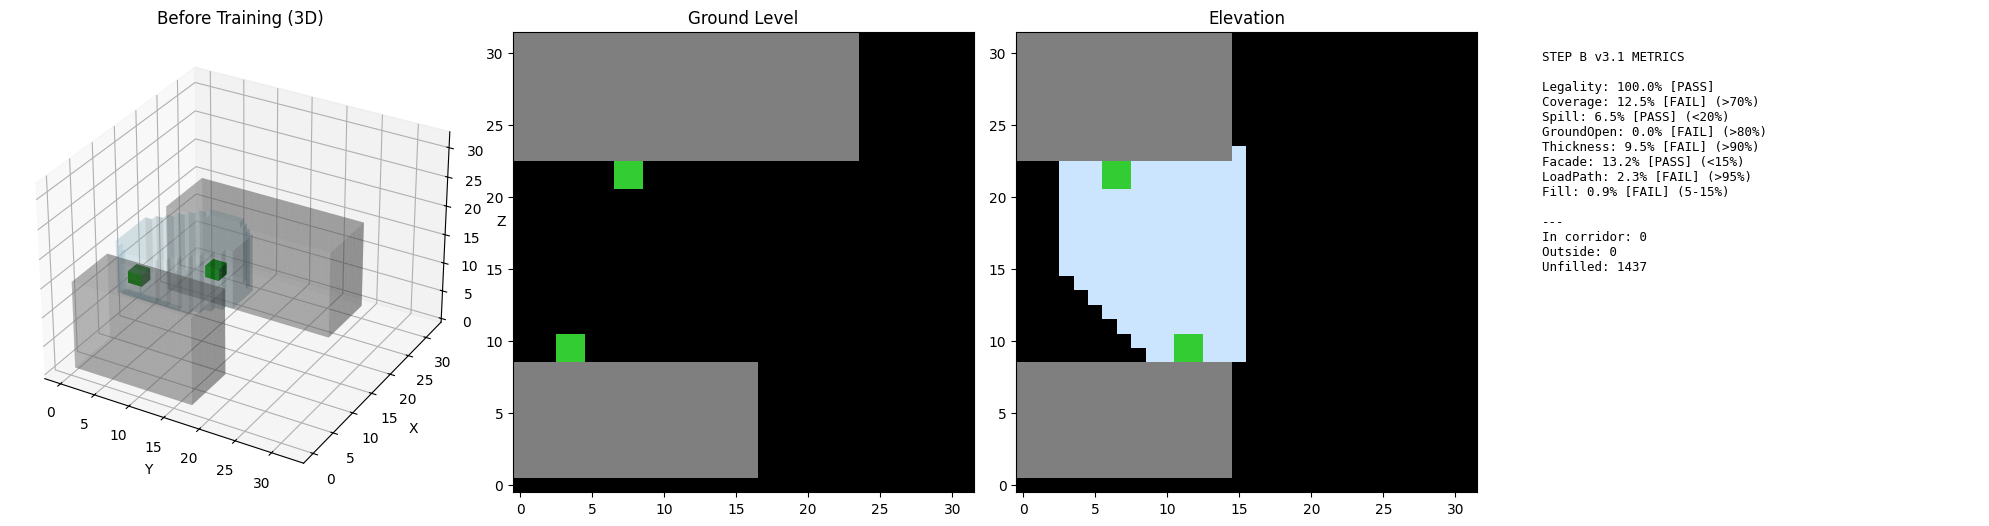

(tensor([[[[[1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
             1.0000e+00, 1.0000e+00],
            [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
             1.0000e+00, 1.0000e+00],
            [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
             1.0000e+00, 1.0000e+00],
            ...,
            [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
             1.0000e+00, 1.0000e+00],
            [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
             1.0000e+00, 1.0000e+00],
            [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
             1.0000e+00, 1.0000e+00]],
 
           [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
             0.0000e+00, 0.0000e+00],
            [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
             0.0000e+00, 0.0000e+00],
            [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
             0.0000e+00, 0.0000e+00],
            ...,
            [0.000

In [21]:
# Before training
print('Before training:')
visualize_v31_result(model, trainer.scene_gen, CONFIG, device, 'Before Training')


STEP B TRAINING v3.1: FIXED LOSS GEOMETRY
KEY FIXES:
  - Split Coverage (A) + Spill (B) - was both spill
  - Corridor from SEED - was current state
  - Ground openness - was missing
  - Thickness=2 - was 4
  - Squared sparsity - was hinge


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch    0 | Loss: 76.17 | Cov: 12% | Spill: 5% | Fill: 0.6% | CorrL: 79% | Cvox: 5277 | Cgnd: 1089 | Acc: 8 | CorrF: 4.0%
Epoch   20 | Loss: 57.75 | Cov: 14% | Spill: 0% | Fill: 0.6% | CorrL: 76% | Cvox: 4803 | Cgnd: 1149 | Acc: 8 | CorrF: 3.7%
Epoch   40 | Loss: 50.22 | Cov: 25% | Spill: 0% | Fill: 1.1% | CorrL: 79% | Cvox: 4691 | Cgnd: 999 | Acc: 8 | CorrF: 3.6%
Epoch   60 | Loss: 28.56 | Cov: 79% | Spill: 1% | Fill: 2.2% | CorrL: 91% | Cvox: 3000 | Cgnd: 269 | Acc: 7 | CorrF: 2.3%
Epoch   80 | Loss: 34.45 | Cov: 55% | Spill: 0% | Fill: 2.3% | CorrL: 56% | Cvox: 4495 | Cgnd: 2023 | Acc: 8 | CorrF: 3.4%
Epoch  100 | Loss: 26.22 | Cov: 79% | Spill: 0% | Fill: 3.6% | CorrL: 79% | Cvox: 4959 | Cgnd: 1028 | Acc: 8 | CorrF: 3.8%


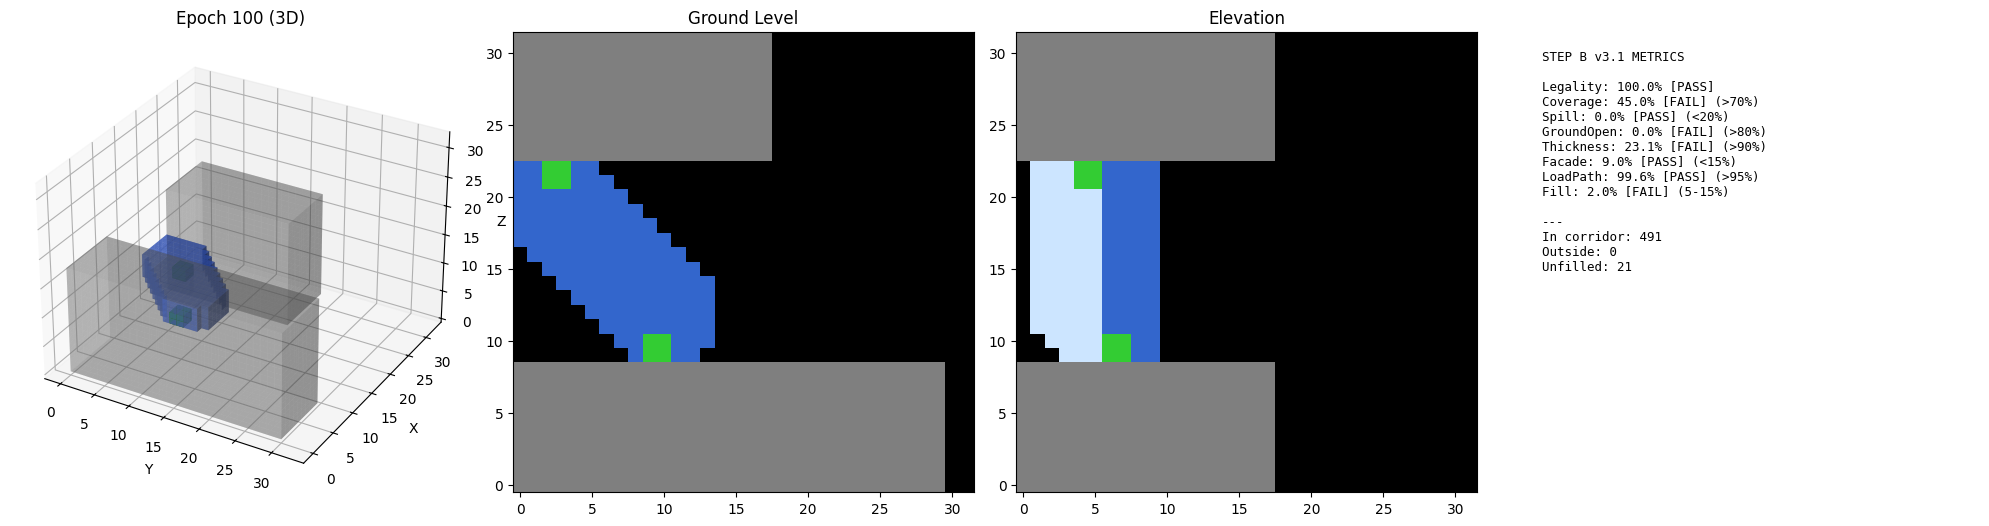

Checkpoint saved: /content/drive/MyDrive/Constraint-NCA/step_b/checkpoints/v31_epoch_100.pth
Epoch  120 | Loss: 33.29 | Cov: 59% | Spill: 0% | Fill: 2.4% | CorrL: 60% | Cvox: 4567 | Cgnd: 1865 | Acc: 8 | CorrF: 3.5%
Epoch  140 | Loss: 23.28 | Cov: 89% | Spill: 0% | Fill: 3.6% | CorrL: 89% | Cvox: 4346 | Cgnd: 478 | Acc: 8 | CorrF: 3.3%
Epoch  160 | Loss: 28.12 | Cov: 77% | Spill: 0% | Fill: 2.6% | CorrL: 78% | Cvox: 3766 | Cgnd: 873 | Acc: 8 | CorrF: 2.9%
Epoch  180 | Loss: 25.86 | Cov: 80% | Spill: 0% | Fill: 3.3% | CorrL: 80% | Cvox: 4529 | Cgnd: 912 | Acc: 8 | CorrF: 3.5%
Epoch  200 | Loss: 24.15 | Cov: 84% | Spill: 0% | Fill: 4.3% | CorrL: 84% | Cvox: 5512 | Cgnd: 873 | Acc: 8 | CorrF: 4.2%


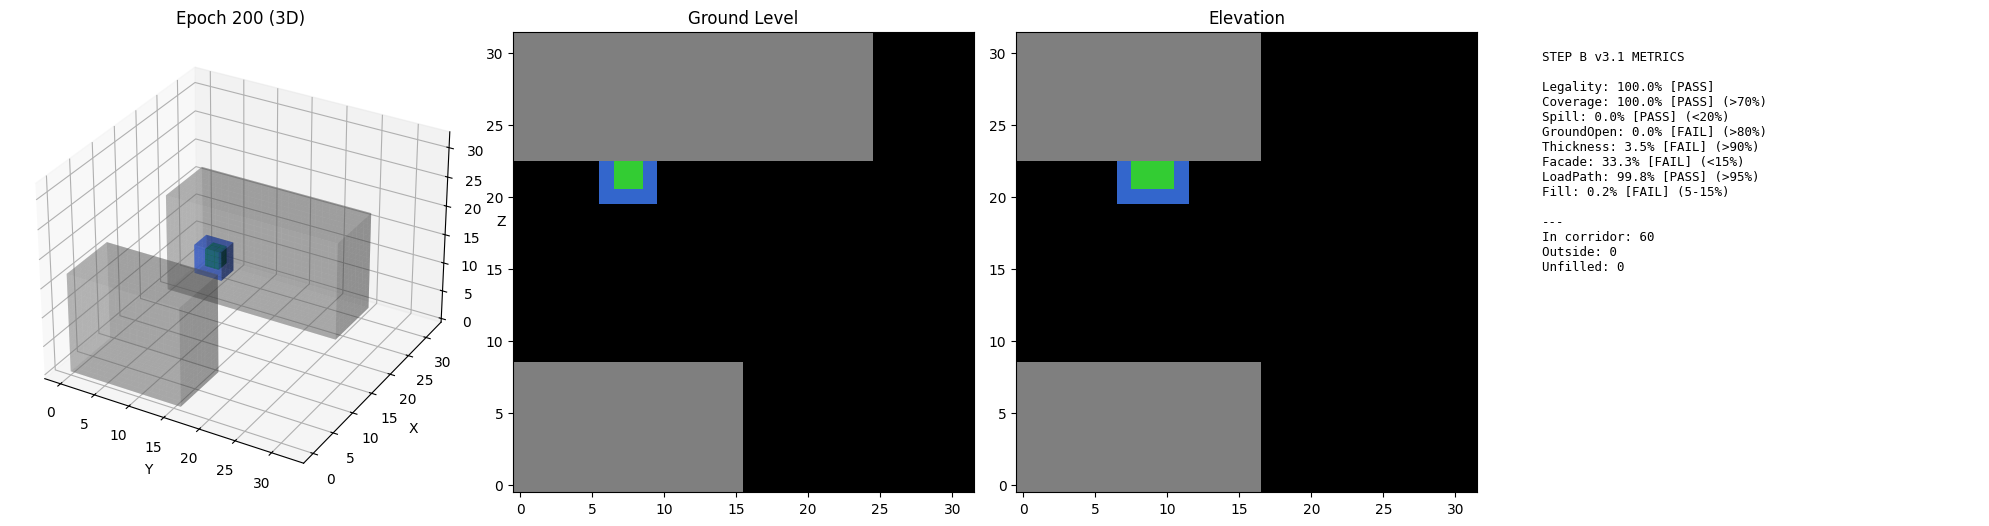

Checkpoint saved: /content/drive/MyDrive/Constraint-NCA/step_b/checkpoints/v31_epoch_200.pth
Epoch  220 | Loss: 22.89 | Cov: 88% | Spill: 0% | Fill: 4.6% | CorrL: 88% | Cvox: 5647 | Cgnd: 690 | Acc: 8 | CorrF: 4.3%
Epoch  240 | Loss: 28.26 | Cov: 73% | Spill: 0% | Fill: 3.0% | CorrL: 74% | Cvox: 4411 | Cgnd: 1188 | Acc: 8 | CorrF: 3.4%
Epoch  260 | Loss: 28.72 | Cov: 77% | Spill: 0% | Fill: 2.6% | CorrL: 78% | Cvox: 3551 | Cgnd: 814 | Acc: 8 | CorrF: 2.7%
Epoch  280 | Loss: 28.31 | Cov: 67% | Spill: 0% | Fill: 4.0% | CorrL: 67% | Cvox: 6582 | Cgnd: 2176 | Acc: 8 | CorrF: 5.0%
Epoch  300 | Loss: 24.41 | Cov: 93% | Spill: 0% | Fill: 2.5% | CorrL: 93% | Cvox: 2863 | Cgnd: 199 | Acc: 7 | CorrF: 2.2%


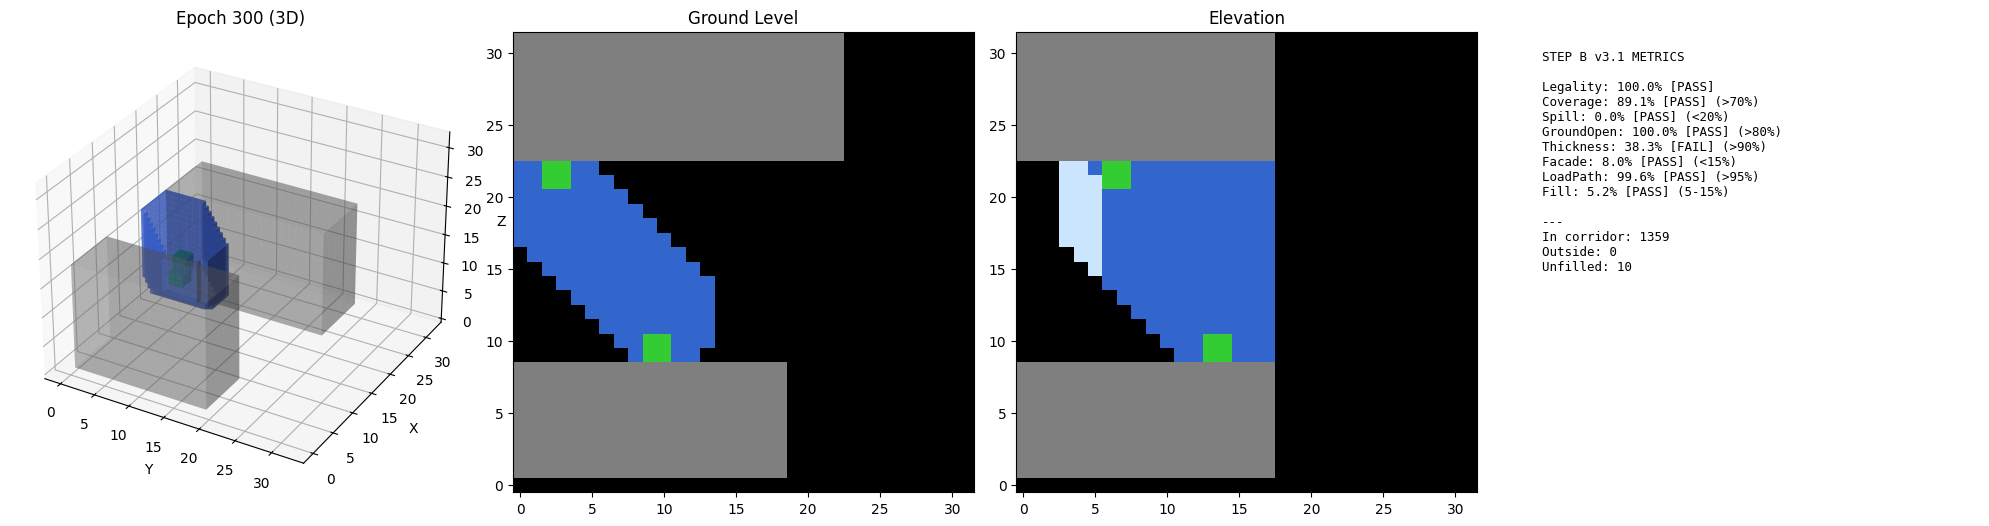

Checkpoint saved: /content/drive/MyDrive/Constraint-NCA/step_b/checkpoints/v31_epoch_300.pth
Epoch  320 | Loss: 29.31 | Cov: 74% | Spill: 0% | Fill: 2.5% | CorrL: 74% | Cvox: 3777 | Cgnd: 973 | Acc: 8 | CorrF: 2.9%
Epoch  340 | Loss: 28.32 | Cov: 69% | Spill: 0% | Fill: 4.4% | CorrL: 69% | Cvox: 6855 | Cgnd: 2125 | Acc: 8 | CorrF: 5.2%
Epoch  360 | Loss: 32.59 | Cov: 63% | Spill: 0% | Fill: 2.9% | CorrL: 64% | Cvox: 5011 | Cgnd: 1852 | Acc: 7 | CorrF: 3.8%
Epoch  380 | Loss: 28.70 | Cov: 79% | Spill: 0% | Fill: 2.3% | CorrL: 79% | Cvox: 3038 | Cgnd: 651 | Acc: 8 | CorrF: 2.3%
Epoch  400 | Loss: 26.09 | Cov: 87% | Spill: 0% | Fill: 2.7% | CorrL: 87% | Cvox: 3223 | Cgnd: 423 | Acc: 8 | CorrF: 2.5%


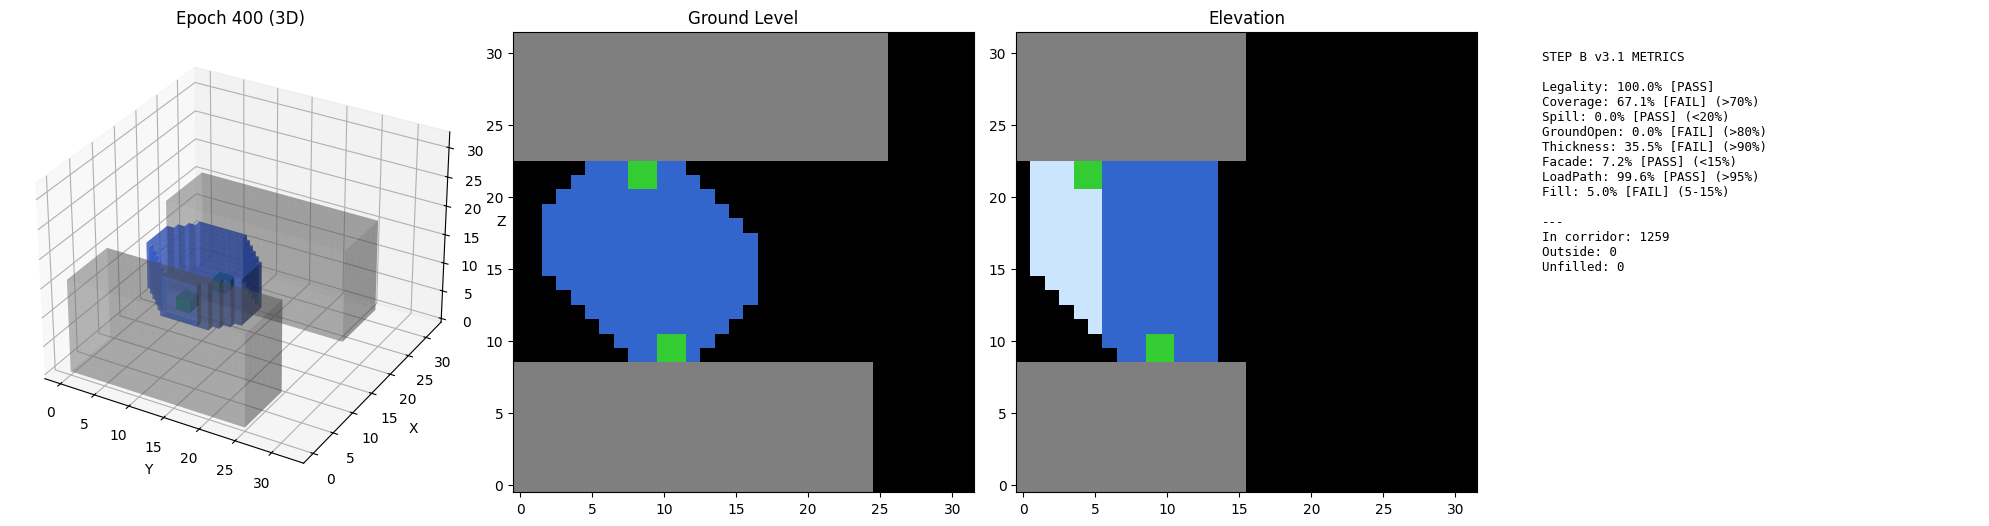

Checkpoint saved: /content/drive/MyDrive/Constraint-NCA/step_b/checkpoints/v31_epoch_400.pth
Epoch  420 | Loss: 31.29 | Cov: 78% | Spill: 0% | Fill: 3.3% | CorrL: 78% | Cvox: 4627 | Cgnd: 1035 | Acc: 8 | CorrF: 3.5%
Epoch  440 | Loss: 28.26 | Cov: 79% | Spill: 0% | Fill: 2.3% | CorrL: 79% | Cvox: 3140 | Cgnd: 673 | Acc: 7 | CorrF: 2.4%
Epoch  460 | Loss: 32.52 | Cov: 66% | Spill: 0% | Fill: 1.8% | CorrL: 67% | Cvox: 2891 | Cgnd: 977 | Acc: 8 | CorrF: 2.2%
Epoch  480 | Loss: 28.45 | Cov: 71% | Spill: 0% | Fill: 3.3% | CorrL: 72% | Cvox: 4845 | Cgnd: 1397 | Acc: 8 | CorrF: 3.7%
Training complete!


In [22]:
# Training loop
print('\n' + '='*70)
print('STEP B TRAINING v3.1: FIXED LOSS GEOMETRY')
print('='*70)
print('KEY FIXES:')
print('  - Split Coverage (A) + Spill (B) - was both spill')
print('  - Corridor from SEED - was current state')
print('  - Ground openness - was missing')
print('  - Thickness=2 - was 4')
print('  - Squared sparsity - was hinge')
print('='*70)

for epoch in tqdm(range(CONFIG['epochs']), desc='Training'):
    metrics = trainer.train_epoch(epoch)

    if epoch % CONFIG['log_every'] == 0:
        tqdm.write(
            f"Epoch {epoch:4d} | Loss: {metrics['total_loss']:.2f} | "
            f"Cov: {metrics['coverage']*100:.0f}% | "
            f"Spill: {metrics['spill']*100:.0f}% | "
            f"Fill: {metrics['fill_ratio']*100:.1f}% | "
            f"CorrL: {metrics['corr_legal_pct']:.0f}% | "
            f"Cvox: {metrics['corr_total']:.0f} | "
            f"Cgnd: {metrics['corr_ground']:.0f} | "
            f"Acc: {metrics['access_centroids']:.0f} | CorrF: {metrics['corridor_fraction']*100:.1f}%"
        )

    if epoch > 0 and epoch % CONFIG['viz_every'] == 0:
        visualize_v31_result(model, trainer.scene_gen, CONFIG, device, f'Epoch {epoch}')

    if epoch > 0 and epoch % CONFIG['save_every'] == 0:
        trainer.save_checkpoint(f"{PROJECT_ROOT}/step_b/checkpoints/v31_epoch_{epoch}.pth")

print('='*70)
print('Training complete!')

## 9. Evaluation

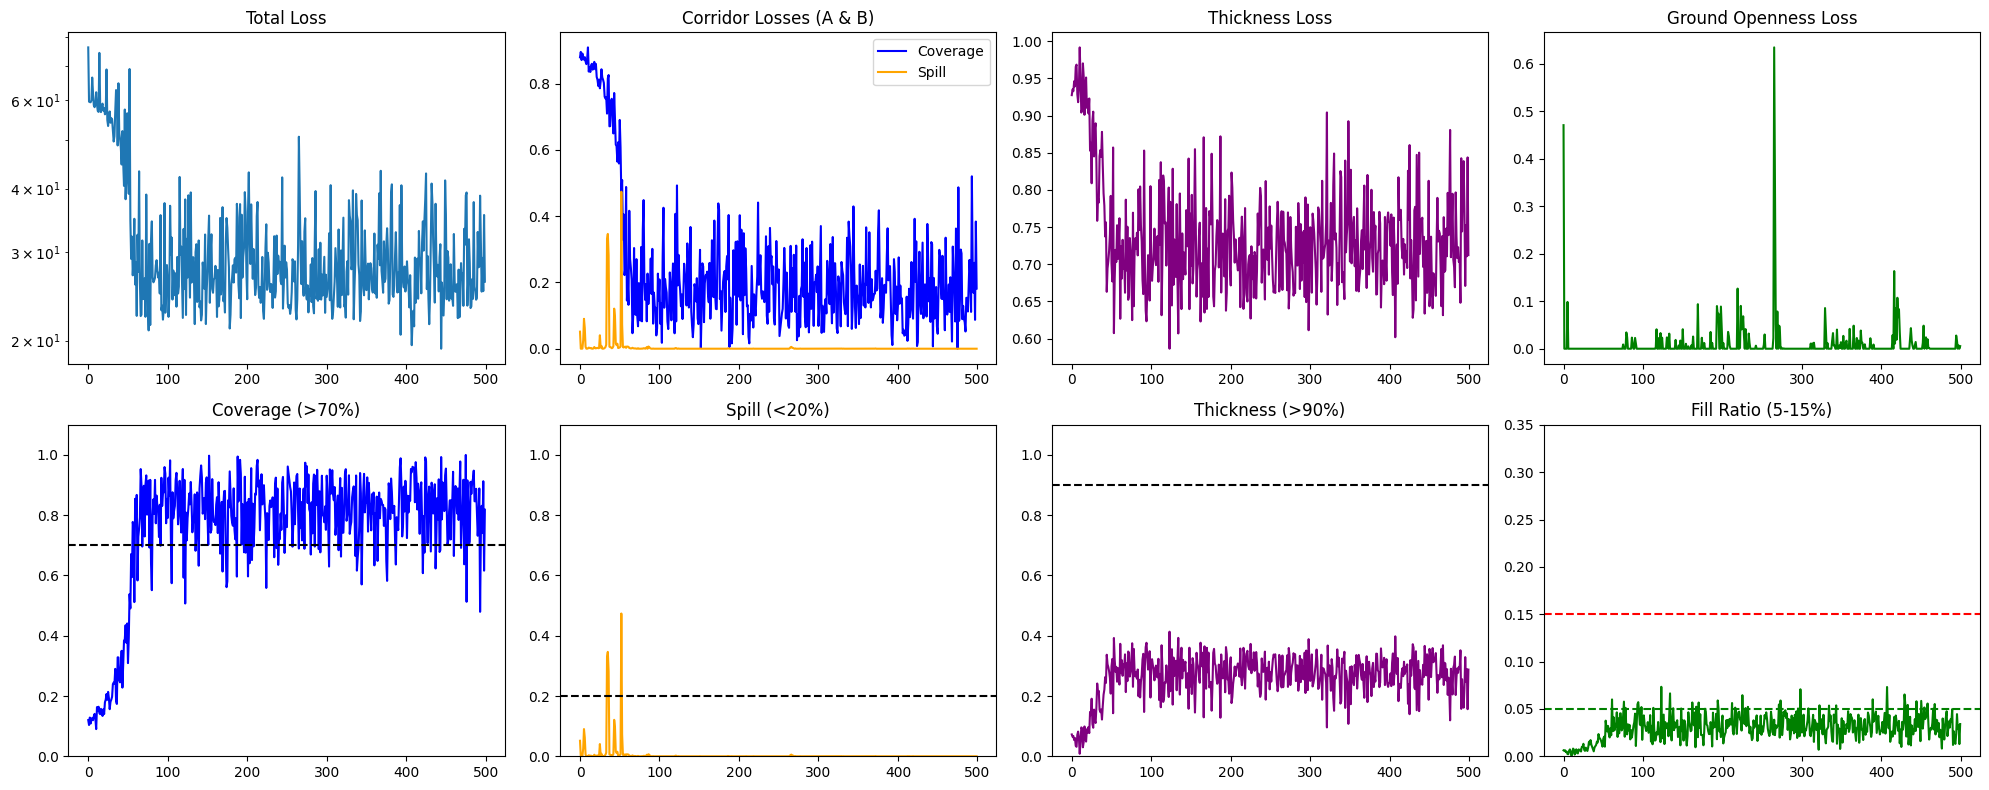

In [23]:
# Plot curves
plot_v31_training_curves(trainer.history)

In [24]:
# Evaluate
print('Evaluating...')
eval_results = trainer.evaluate(n_samples=50)

print('\n' + '='*70)
print('STEP B v3.1 EVALUATION RESULTS')
print('='*70)

p_leg = eval_results['avg_legality'] > 0.99
p_cov = eval_results['avg_coverage'] > 0.70
p_spl = eval_results['avg_spill'] < 0.20
p_gnd = eval_results['avg_ground_open'] > 0.80
p_thick = eval_results['avg_thickness'] > 0.90
p_fac = eval_results['avg_facade'] < 0.15
p_load = eval_results['avg_loadpath'] > 0.95
p_acc = eval_results['avg_access_reach'] > 0.90
p_fill = 0.05 < eval_results['avg_fill_ratio'] < 0.15

print(f"Legality:      {eval_results['avg_legality']*100:.1f}% {'PASS' if p_leg else 'FAIL'} (target 100%)")
print(f"Coverage:      {eval_results['avg_coverage']*100:.1f}% {'PASS' if p_cov else 'FAIL'} (target >70%)")
print(f"Spill:         {eval_results['avg_spill']*100:.1f}% {'PASS' if p_spl else 'FAIL'} (target <20%)")
print(f"Ground Open:   {eval_results['avg_ground_open']*100:.1f}% {'PASS' if p_gnd else 'FAIL'} (target >80%)")
print(f"Thickness:     {eval_results['avg_thickness']*100:.1f}% {'PASS' if p_thick else 'FAIL'} (target >90%)")
print(f"Facade:        {eval_results['avg_facade']*100:.1f}% {'PASS' if p_fac else 'FAIL'} (target <15%)")
print(f"Load Path:     {eval_results['avg_loadpath']*100:.1f}% {'PASS' if p_load else 'FAIL'} (target >95%)")
print(f"Access Reach:  {eval_results['avg_access_reach']*100:.1f}% {'PASS' if p_acc else 'FAIL'} (target >90%)")
print(f"Fill Ratio:    {eval_results['avg_fill_ratio']*100:.1f}% {'PASS' if p_fill else 'FAIL'} (target 5-15%)")
print('='*70)

all_pass = p_leg and p_cov and p_spl and p_gnd and p_thick and p_fac and p_load and p_acc and p_fill
if all_pass:
    print('\nALL CRITERIA PASSED!')
else:
    print('\nSome criteria not met - analyze results')

Evaluating...

STEP B v3.1 EVALUATION RESULTS
Legality:      100.0% PASS (target 100%)
Coverage:      4.0% FAIL (target >70%)
Spill:         0.7% PASS (target <20%)
Ground Open:   14.0% FAIL (target >80%)
Thickness:     1.3% FAIL (target >90%)
Facade:        43.9% FAIL (target <15%)
Load Path:     99.9% PASS (target >95%)
Access Reach:  62.0% FAIL (target >90%)
Fill Ratio:    0.1% FAIL (target 5-15%)

Some criteria not met - analyze results



Final Results:


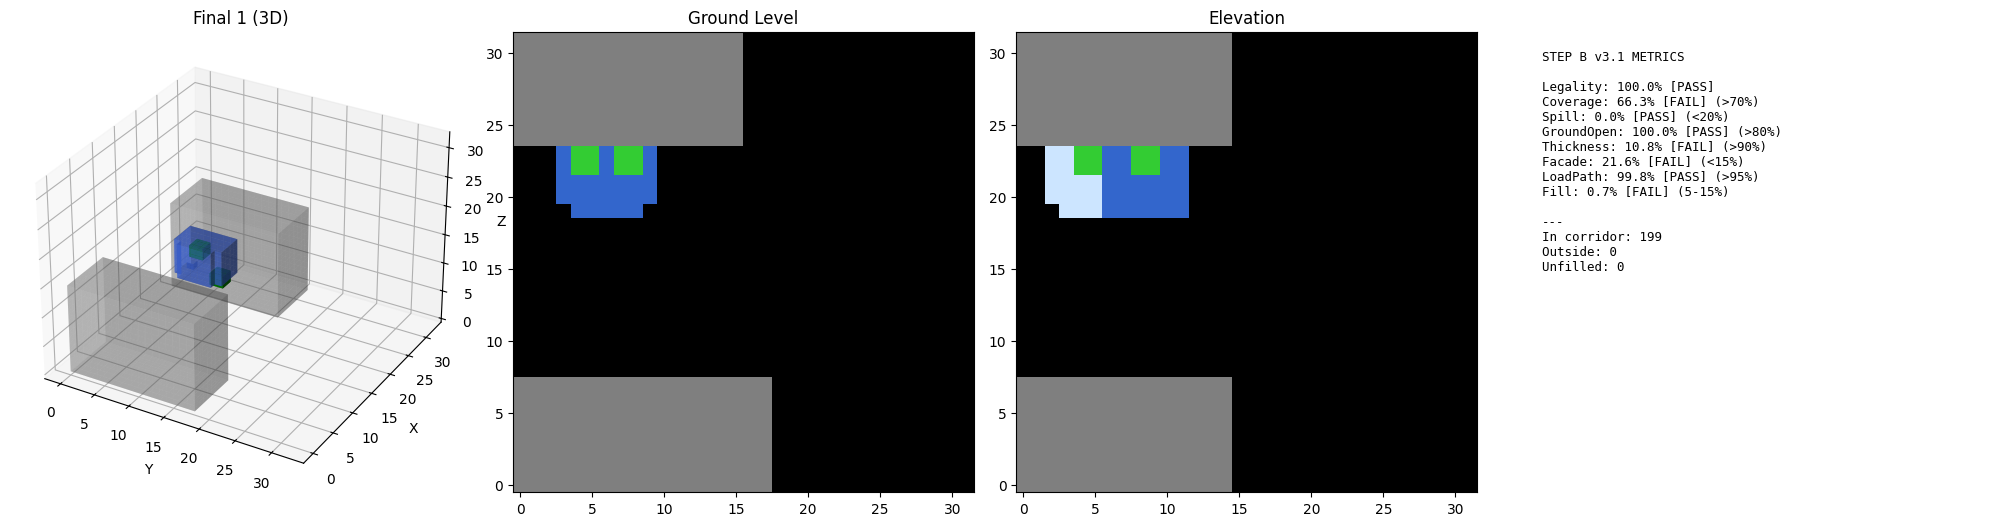

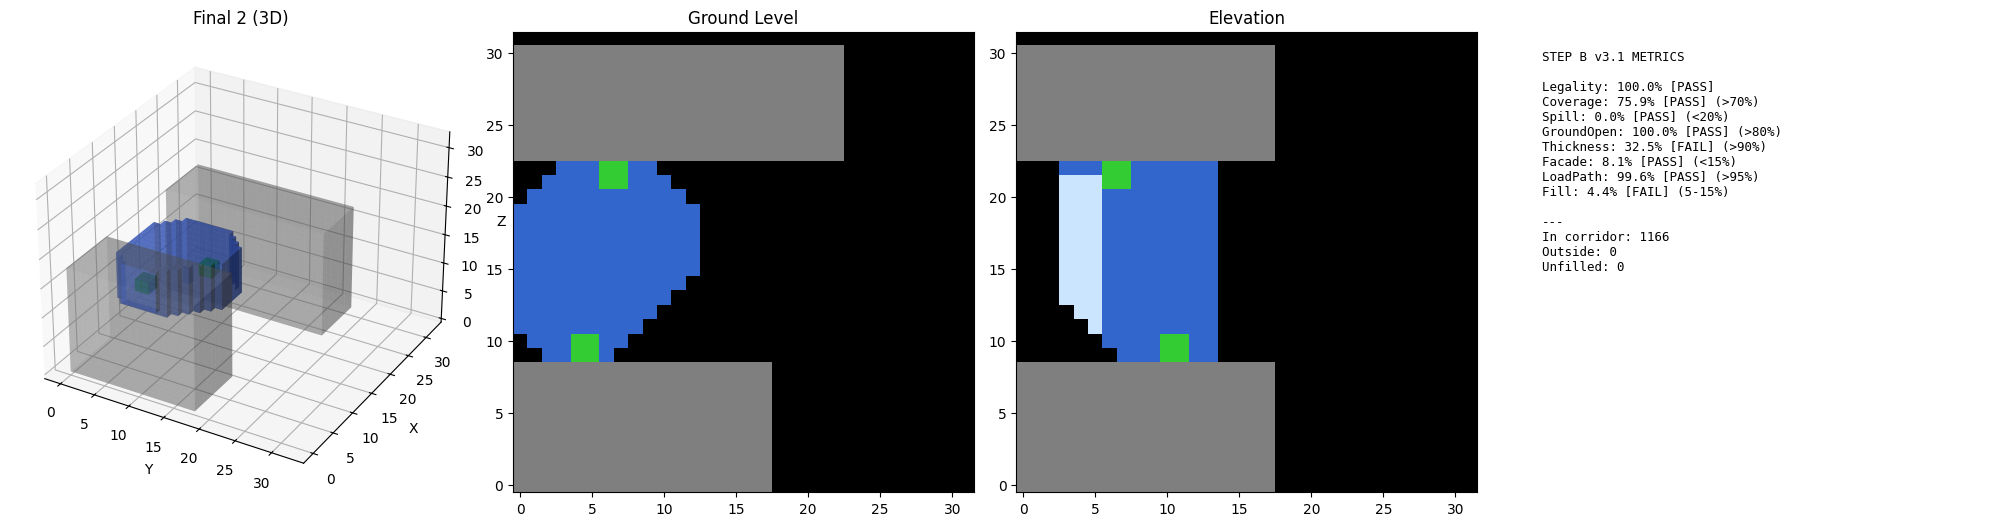

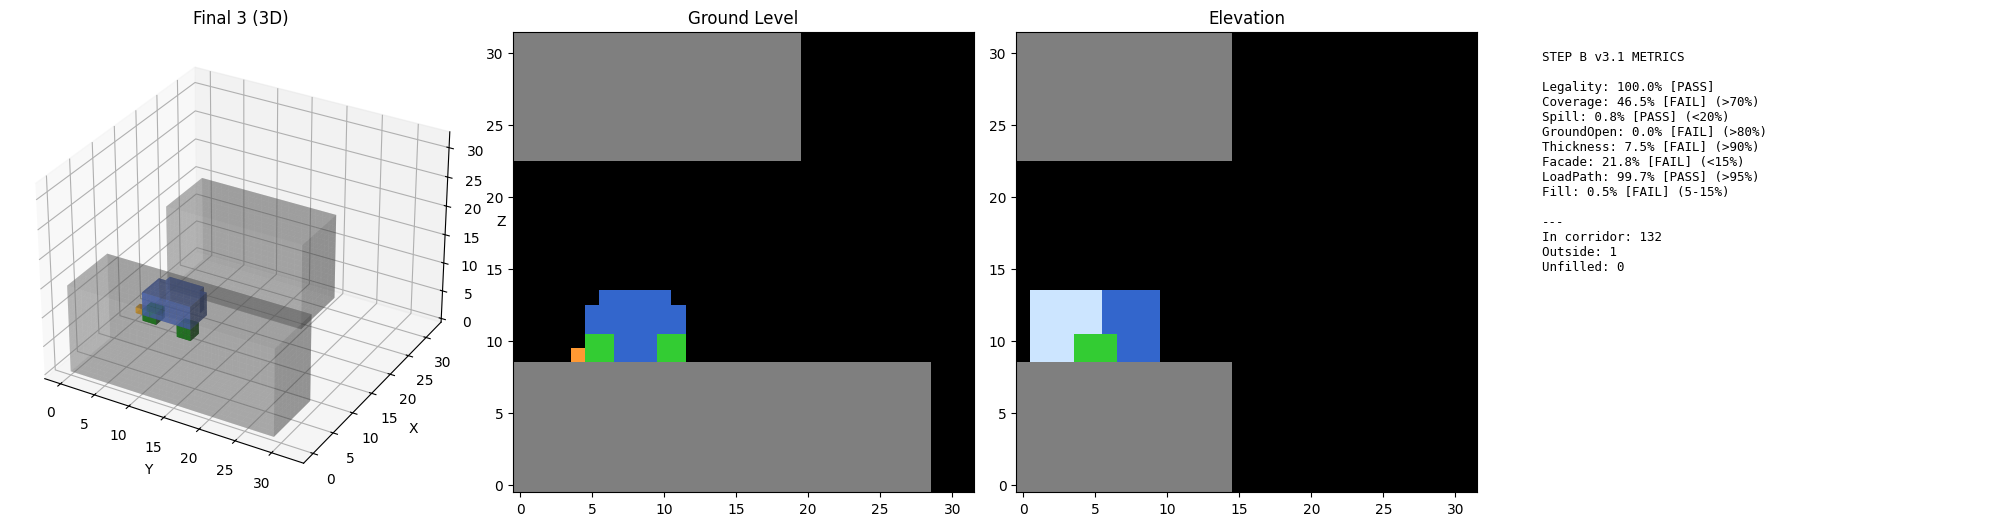

In [25]:
# Final visualizations
print('\nFinal Results:')
for i in range(3):
    visualize_v31_result(model, trainer.scene_gen, CONFIG, device, f'Final {i+1}')

## 10. Save Final Checkpoint

In [26]:
# Save final
trainer.save_checkpoint(f"{PROJECT_ROOT}/step_b/checkpoints/v31_fixed_geometry.pth")

# Save history
with open(f"{PROJECT_ROOT}/step_b/logs/v31_training_history.json", 'w') as f:
    json.dump(trainer.history, f)

# Save eval
with open(f"{PROJECT_ROOT}/step_b/logs/v31_evaluation.json", 'w') as f:
    json.dump(eval_results, f, indent=2)

print('\nAll outputs saved')
print(f"Checkpoint: {PROJECT_ROOT}/step_b/checkpoints/v31_fixed_geometry.pth")

Checkpoint saved: /content/drive/MyDrive/Constraint-NCA/step_b/checkpoints/v31_fixed_geometry.pth

All outputs saved
Checkpoint: /content/drive/MyDrive/Constraint-NCA/step_b/checkpoints/v31_fixed_geometry.pth


## Summary

### Step B Training v3.1 - Fixed Loss Geometry

**Problem in v3.0:** PathConnectivity and OutsideTarget were both "spill" losses.

**v3.1 Fixes:**

| Fix | v3.0 | v3.1 |
|-----|------|------|
| Corridor intent | Both spill (B+B) | Coverage + Spill (A+B) |
| Corridor source | Current state | Seed state (frozen) |
| Ground openness | Missing | Explicit loss |
| max_thickness | 4 | 2 |
| Sparsity | Hinge | Squared |
| corridor_width | 3 | 4 |

### Loss Architecture

| Loss | Purpose | Weight |
|------|---------|--------|
| CorridorCoverage | Fill the corridor (A) | 25.0 |
| CorridorSpill | Don't grow outside (B) | 25.0 |
| GroundOpenness | Preserve street | 15.0 |
| Thickness | Prevent blobs | 20.0 |
| SparsityV31 | Volume limit | 25.0 |

### Success Criteria

| Metric | Target |
|--------|--------|
| Coverage | >70% |
| Spill | <20% |
| Ground open | >80% |
| Thickness | >90% |
| Fill ratio | 5-15% |

---

*NB02_AllConstraints_v3.1 - Fixed Loss Geometry - December 2025*